In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches

plt.style.use('seaborn-v0_8-whitegrid')

# Contexto

**Swetro** es una aplicación en la que los usuarios se registran para competir en retos deportivos de running, ciclismo y caminata, ya sea para ganar premios o simplemente por el espíritu de competencia. Para participar, los usuarios registran sus actividades mediante relojes inteligentes de marcas como Garmin, Suunto, Wahoo, IgpSport, Polar y Apple Watch, o a través de las apps móviles oficiales de estas marcas desde un dispositivo móvil.

Uno de los desafíos recurrentes que enfrenta Swetro es la detección de actividades sospechosas o incoherentes, las cuales pueden surgir por diversas razones, tales como:

*   Errores en los sensores de los dispositivos, lo que genera registros  
incorrectos en métricas cómo la velocidad, distancia o ritmo cardíaco.

*  Registros humanamente imposibles, como velocidades extremas o distancias cubiertas en tiempos irrealistas.

*  Uso inadecuado del dispositivo, por ejemplo, dejarlo encendido todo el día sin realizar actividad física real.

*  Intento de fraude, donde un usuario registra una actividad pero en realidad realizó otra (ejemplo: marcar una caminata como un trote).

*  Aprovechamiento de medios externos, como subirse a un vehículo o utilizar una bicicleta eléctrica para obtener mejores tiempos y distancias.

Por lo tanto, para evitar que estas irregularidades afecten la competencia justa y la validez de los premios, es necesario desarrollar un sistema de detección de actividades atípicas o sospechosas.

Para este estudio, se utilizará un dataset de los últimos 5 meses (octubre 2024 - febrero 2025) con registros de actividades deportivas:

*  Cada fila representa una actividad registrada por un usuario.
*  Cada columna corresponde a una variable o característica de la actividad, como distancia, tiempo, velocidad promedio, ritmo cardíaco promedio, elevación ganada, etc.

Dado que las irregularidades pueden variar según la disciplina deportiva, este análisis se centrará exclusivamente en los registros de running, buscando patrones que indiquen posibles fraudes o datos erróneos.

## Descripción de los campos

Las variables que describen cada actividad son los siguientes:

*  **UserId:** Identificador único del usuario en la base de datos de la empresa.
*  **Type:** Tipo de actividad registrada (*Running, Cycling, Walking, Other*).
*  **Name:** Nombre asignado a la actividad, ya sea por el usuario o automáticamente por la aplicación.
*  **StartTimeUtc:** Fecha y hora de inicio de la actividad en UTC (*Tiempo Universal Coordinado*).
*  **DurationInSeconds:** Duración total de la actividad medida en segundos.
*  **DistanceInMeters:** Distancia recorrida durante la actividad, expresada en metros.
*  **Steps:** Número total de pasos registrados durante la actividad.
*  **AverageSpeedInMetersPerSecond:** Velocidad promedio alcanzada durante la actividad, expresada en metros por segundo.
*  **AveragePaceInMinutesPerKilometer:** Ritmo promedio de la actividad, expresado en minutos por kilómetro.
*  **TotalElevationGainInMeters:** Suma total de la elevación ganada en la actividad, expresada en metros.
*  **TotalElevationLossInMeters:** Suma total de la elevación perdida en la actividad, expresada en metros.
*  **AverageHeartRateInBeatsPerMinute:** Frecuencia cardíaca promedio durante la actividad, medida en latidos por minuto (*BPM*).
*  **SourceType:** Marca del dispositivo con el cual se registró la actividad (*Garmin, Suunto, Wahoo, IgpSports, Polar, Apple Watch*).
*  **SourceName:** Modelo del dispositivo o aplicación que registró la actividad (ejemplo: *Garmin Forerunner 945, fēnix 3 HR, etc*).
*  **Warnings:** Indicadores de posibles anomalías detectadas en la actividad. Se generan alertas en los siguientes casos:
  1.  Si la duración de la actividad es menor a 5 minutos.
  2.  Si es una actividad de ciclismo y la elevación ganada supera los 16 metros por minuto (1,000 metros por hora).
  3.  Si es una actividad de running y la elevación ganada supera los 8 metros por minuto (500 metros por hora).
  4.  Si es una actividad de running con un ritmo promedio menor a 3.5 minutos por kilómetro (3:30 min/km).
  5.  Si la actividad no registra distancia recorrida.

*  **CreationTime:** Fecha y hora en la que el registro de la actividad fue creado en la base de datos.

## Pregunta SMART
¿Es posible identificar actividades de running atípicas o sospechosas con datos
de los últimos 5 meses (10/2024 - 02/2025) utilizando métricas cómo velocidad,
distancia, elevación, tiempo y frecuencia cardiaca?

# Análisis exploratorio

Empezaremos por revisar la estructura del dataset, la consistencia entre los datos y que tengan el formato adecuado.



## Análisis de estructura

In [73]:
df = pd.read_excel('./DatasetActivitiesRunning.xlsx', engine="openpyxl")
df_original = df.copy()
df.shape

(351195, 16)

Los datos cuentan con 351.195 observaciones y 16 columnas

In [74]:
df.head()

,UserId,Type,Name,StartTimeUtc,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,TotalElevationGainInMeters,TotalElevationLossInMeters,AverageHeartRateInBeatsPerMinute,SourceType,SourceName,Warnings,CreationTime
0,56226720,Running,Avellaneda Carrera,2024-09-30 20:36:15.0000000 +00:00,2308,6050.10,6802.0,2.622,6.356471,127.971985,128.66255,145.0,Garmin,Forerunner 35,NaN,2024-10-01 00:00:32.7421846 +00:00
1,33958672,Running,Malvinas Argentinas Carrera,2024-09-30 23:43:23.0000000 +00:00,232,557.72,600.0,2.399,6.947340,NaN,1.00000,91.0,Garmin,Forerunner 255S Music,DurationLessThanFiveMinutes,2024-10-01 00:00:37.8144259 +00:00
2,33958672,Running,Malvinas Argentinas Carrera,2024-09-30 23:53:23.0000000 +00:00,320,770.48,856.0,2.407,6.924248,3.000000,1.00000,114.0,Garmin,Forerunner 255S Music,NaN,2024-10-01 00:00:52.2962825 +00:00
3,39156304,Running,Córdoba Carrera,2024-09-30 23:26:07.0000000 +00:00,1895,5005.62,5254.0,2.642,6.308352,96.905790,107.28553,146.0,Garmin,Forerunner 45,NaN,2024-10-01 00:01:02.0718947 +00:00
4,10154408,Running,Rosario Carrera,2024-09-30 21:59:39.0000000 +00:00,4386,10376.22,11452.0,2.365,7.047216,71.099960,71.93257,143.0,Garmin,Forerunner 55,NaN,2024-10-01 00:01:30.1037912 +00:00


In [5]:
df.isna().sum()

UserId                                   0
Type                                     0
Name                                     0
StartTimeUtc                             0
DurationInSeconds                        0
DistanceInMeters                       979
Steps                                 4008
AverageSpeedInMetersPerSecond          994
AveragePaceInMinutesPerKilometer      1052
TotalElevationGainInMeters           33316
TotalElevationLossInMeters           32925
AverageHeartRateInBeatsPerMinute     13214
SourceType                               0
SourceName                             999
Warnings                            316327
CreationTime                             0
dtype: int64

Se puede ver que hay datos vacíos, para las variables DistanceInMeters, Steps, AverageSpeedInMetersPerSeconds, AveragePaceInMinutesPerKilometer, TotalElevationGainInMeters,TotalElevationLossInMeters, AverageHeartRateInBeatsPerMinute, SourceName y Warnings. En el proceso de limpieza se decidirá qué hacer con estas observaciones.

In [6]:
list(df.columns)

['UserId',
 'Type',
 'Name',
 'StartTimeUtc',
 'DurationInSeconds',
 'DistanceInMeters',
 'Steps',
 'AverageSpeedInMetersPerSecond',
 'AveragePaceInMinutesPerKilometer',
 'TotalElevationGainInMeters',
 'TotalElevationLossInMeters',
 'AverageHeartRateInBeatsPerMinute',
 'SourceType',
 'SourceName',
 'Warnings',
 'CreationTime']

## Análisis de variables categóricas

A continuación vamos a observar los tipos de dato de cada variable:

In [7]:
df.dtypes

UserId                                int64
Type                                 object
Name                                 object
StartTimeUtc                         object
DurationInSeconds                     int64
DistanceInMeters                    float64
Steps                               float64
AverageSpeedInMetersPerSecond       float64
AveragePaceInMinutesPerKilometer    float64
TotalElevationGainInMeters          float64
TotalElevationLossInMeters          float64
AverageHeartRateInBeatsPerMinute    float64
SourceType                           object
SourceName                           object
Warnings                             object
CreationTime                         object
dtype: object

Podemos observar que el dataset cuenta con las siguientes variables categóricas: Type, Name, StartTimeUtc, SourceType, SourceName, Warnings y CreationTime.

Type
Running    351195
Name: count, dtype: int64


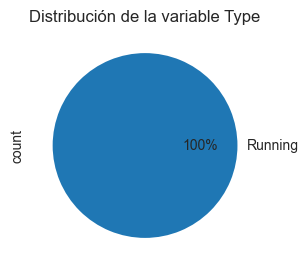

In [8]:
# Análisis de la variable Type
print(df['Type'].value_counts())

# Grafica de torta de la variable Type
plt.figure(figsize=(3, 3))
df['Type'].value_counts().plot.pie(autopct='%1.0f%%', startangle=180)
plt.title('Distribución de la variable Type')
plt.show()

Debido a que Type representa el tipo de actividad deportiva y en el presente análisis sólo se tienen registros de Running, en el proceso de limpieza se eliminará está columna ya que no aporta información valiosa para el modelo.

Name
Bogotá, D.C. Carrera                             18558
Running                                          14549
Coros workout                                    10873
Ciudad de Buenos Aires Carrera                    5706
Cali Carrera                                      5404
                                                 ...  
Xochimilco - 1 km + Fartlek 50 m x 50 m + 4 k        1
Santo Domingo - Caminar: 25' @ Suave                 1
Guayaquil - Recovery and Rest Run                    1
Corregidora - 1600s                                  1
Avellaneda - Fondo en zona 2                         1
Name: count, Length: 46884, dtype: int64


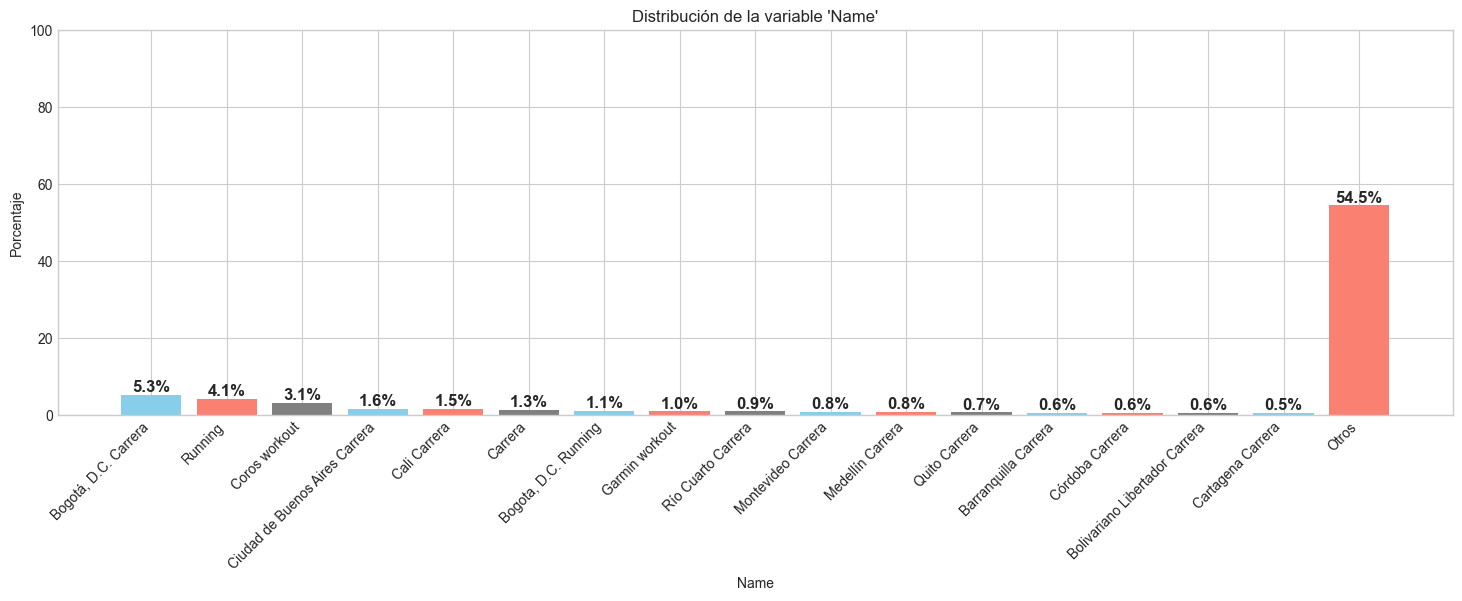

In [9]:
# Análisis de la variable Name
print(df['Name'].value_counts())

porcentajes = (df.value_counts('Name', normalize=True) * 100).round(2)

porcentajes.sort_values(ascending=False, inplace=True)

umbral = 0.5
categorias_importantes = porcentajes[porcentajes >= umbral]
otros = porcentajes[porcentajes < umbral].sum()
if otros > 0:
    categorias_importantes["Otros"] = otros

plt.figure(figsize=(18, 5))
bars = plt.bar(categorias_importantes.index, categorias_importantes, color=['skyblue', 'salmon', 'gray'])

for bar, porcentaje in zip(bars, categorias_importantes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Name")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'Name'")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.show()

En la anterior gráfica se enseñan algunos de los nombres que representan al menos el 0.5% de los nombres encontrados, en cualquier otro caso se agregarían a la categoría de otros para poder mejorar la visualización de los datos.

Esta variable representa el nombre de la actividad que le coloca el reloj o el usuario manualmente, esta variable no es relevante para el análisis por lo que en el proceso de limpieza se eliminará.

In [10]:
# Análisis de la variable StartTimeUtc
print(df['StartTimeUtc'].value_counts())

StartTimeUtc
2025-02-16 10:20:30.0000000 +00:00    11
2025-02-16 10:20:34.0000000 +00:00    10
2025-02-16 10:20:33.0000000 +00:00     9
2025-02-14 13:42:18.0000000 +00:00     7
2025-02-16 10:20:29.0000000 +00:00     7
                                      ..
2024-11-17 00:11:10.0000000 +00:00     1
2024-11-16 02:13:03.0000000 +00:00     1
2024-11-16 01:44:36.0000000 +00:00     1
2024-10-06 20:38:56.0000000 +00:00     1
2025-02-22 21:32:14.0000000 +00:00     1
Name: count, Length: 336508, dtype: int64


La variable StartTimeUtc representa la fecha y hora en la cual se inició la actividad, en los siguientes pasos se podría transformar en nuevas columnas que representen cada valor por separado para poder realizar un mejor análisis de su valor.

In [11]:
# Análisis de SourceType
print(df['SourceType'].value_counts())
(df.value_counts('SourceType', normalize=True) * 100).round(2).astype(str) + '%'

SourceType
Garmin    321978
Coros      11248
Polar       9628
Wahoo       4287
Suunto      3965
Apple         89
Name: count, dtype: int64


SourceType
Garmin    91.68%
Coros       3.2%
Polar      2.74%
Wahoo      1.22%
Suunto     1.13%
Apple      0.03%
Name: proportion, dtype: object

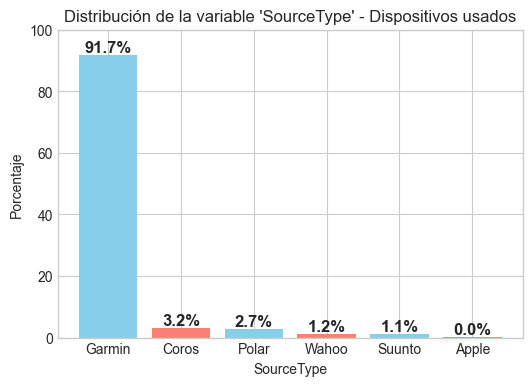

In [12]:
porcentajes = (df.value_counts('SourceType', normalize=True) * 100).round(2)

plt.figure(figsize=(6, 4))
bars = plt.bar(porcentajes.index, porcentajes, color=['skyblue', 'salmon'])

# Agregar las etiquetas
for bar, porcentaje in zip(bars, porcentajes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("SourceType")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'SourceType' - Dispositivos usados")
plt.ylim(0, 100)
plt.show()

En la gráfica anterior, se observa que Garmin domina ampliamente como la marca más utilizada. Esto podría introducir sesgos en el modelo, ya que la distribución está fuertemente inclinada hacia esta marca. Por ello, durante el proceso de limpieza, evaluaremos qué acciones tomar con esta variable, dado que el dataset muestra un claro desbalance.

In [13]:
# Análisis de la variable SourceName
print(df['SourceName'].value_counts())
(df.value_counts('SourceName', normalize=True) * 100).round(2).astype(str) + '%'

SourceName
Forerunner 55           26785
Forerunner 235          19261
Forerunner 245 Music    16618
Forerunner 965          15487
Forerunner 45           14207
                        ...  
Apple Watch Ultra           1
Amazfit GTS 4 Mini          1
Instinct Crossover          1
Approach S70 – 42mm         1
Suunto Race S               1
Name: count, Length: 240, dtype: int64


SourceName
Forerunner 55           7.65%
Forerunner 235           5.5%
Forerunner 245 Music    4.75%
Forerunner 965          4.42%
Forerunner 45           4.06%
                        ...  
fenix 6S Solar           0.0%
Suunto Race S            0.0%
Wahoo ELEMNT RIVAL       0.0%
Apple Watch Ultra        0.0%
Amazfit GTS 4 Mini       0.0%
Name: proportion, Length: 240, dtype: object

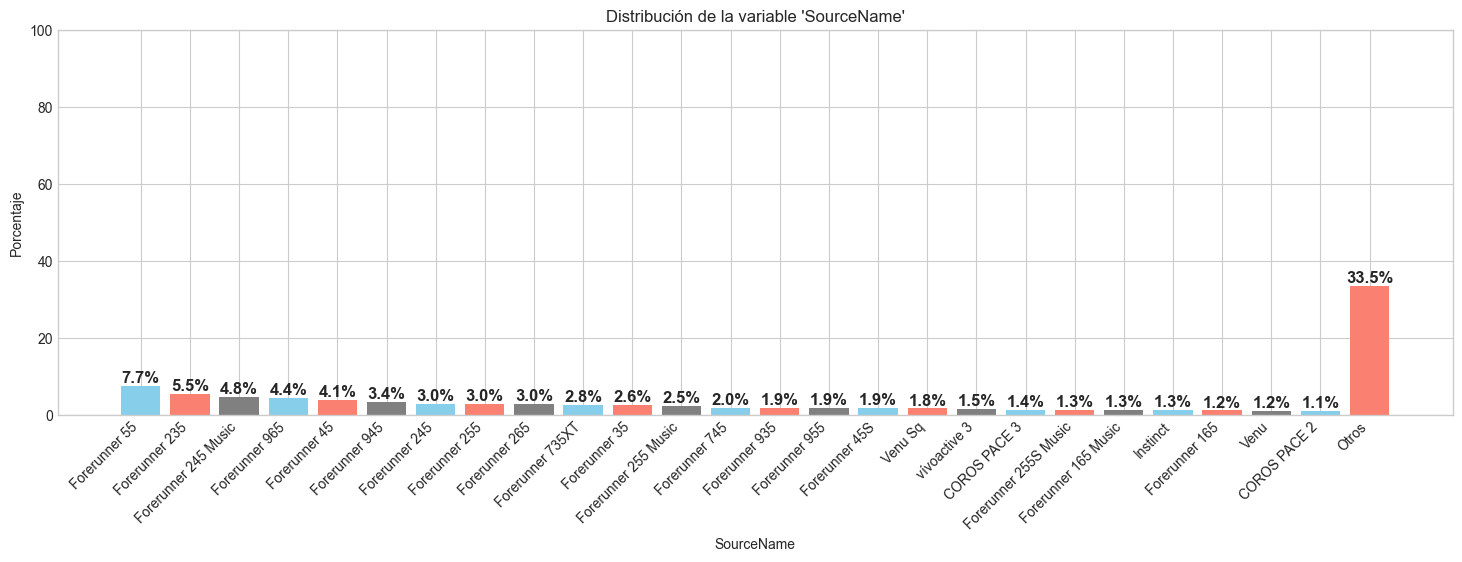

In [14]:
porcentajes = (df.value_counts('SourceName', normalize=True) * 100).round(2)

porcentajes.sort_values(ascending=False, inplace=True)

umbral = 1
categorias_importantes = porcentajes[porcentajes >= umbral]
otros = porcentajes[porcentajes < umbral].sum()
if otros > 0:
    categorias_importantes["Otros"] = otros

plt.figure(figsize=(18, 5))
bars = plt.bar(categorias_importantes.index, categorias_importantes, color=['skyblue', 'salmon', 'gray'])

for bar, porcentaje in zip(bars, categorias_importantes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("SourceName")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'SourceName'")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.show()

En la anterior gráfica se enseñan algunos de los modelos que representan al menos el 1% de los modelos encontrados, en cualquier otro caso se agregarían a la categoría de otros para poder mejorar la visualización delos datos.

En el proceso de limpieza se podría evaluar si se podría eliminar la variable debido a que ya se encuentra representada en la varible sourceType, o se podría realizar algún tratamiento para representar de otra forma.

Warnings
DurationLessThanFiveMinutes                                       18932
DurationLessThanFiveMinutes - AveragePaceInMinutesPerKilometer     5367
TotalElevationGainInMeters                                         4955
AveragePaceInMinutesPerKilometer                                   1671
DurationLessThanFiveMinutes - TotalElevationGainInMeters           1638
                                                                  ...  
Overlapping:1624916                                                   1
Overlapping:1617901                                                   1
Overlapping:1610868                                                   1
Overlapping:1599712                                                   1
Overlapping:2023110                                                   1
Name: count, Length: 107, dtype: int64


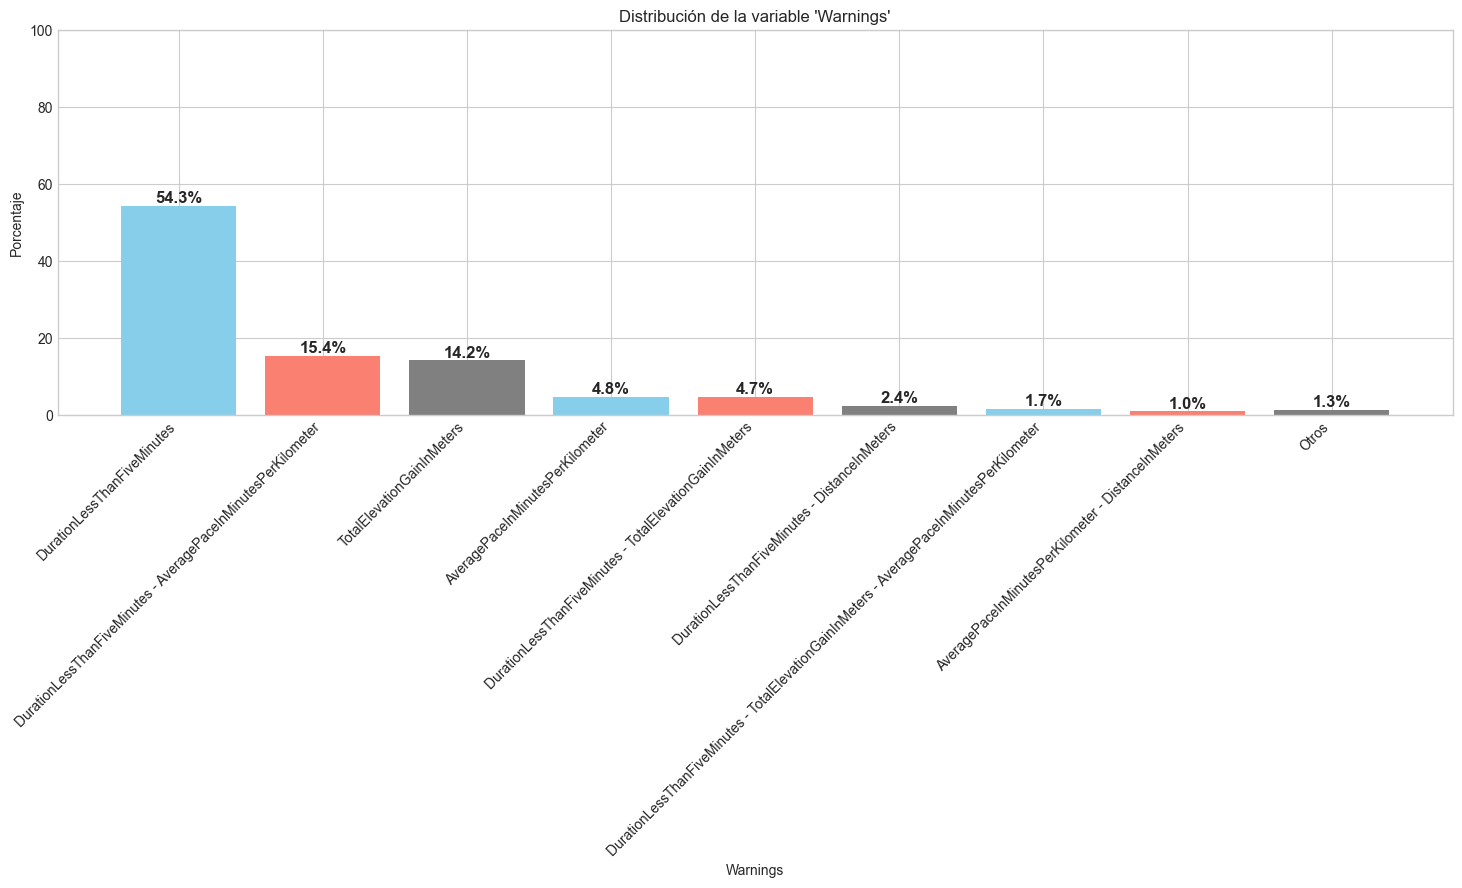

In [15]:
# Análisis de la variable Warnings
print(df['Warnings'].value_counts())

porcentajes = (df.value_counts('Warnings', normalize=True) * 100).round(2)

porcentajes.sort_values(ascending=False, inplace=True)

umbral = 1
categorias_importantes = porcentajes[porcentajes >= umbral]
otros = porcentajes[porcentajes < umbral].sum()
if otros > 0:
    categorias_importantes["Otros"] = otros

plt.figure(figsize=(18, 5))
bars = plt.bar(categorias_importantes.index, categorias_importantes, color=['skyblue', 'salmon', 'gray'])

for bar, porcentaje in zip(bars, categorias_importantes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Warnings")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'Warnings'")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.show()

La variable warnings representa la clasificación manual que realiza la empresa para identificar datos atípicos basados en reglas del negocio, por esta razón en el proceso de limpieza se procederá a eliminar esta columna debido a que puede representar un data leakage y por lo tanto sesgaría el modelo.

In [16]:
# Análisis de la variable CreationTime
print(df['CreationTime'].value_counts())

CreationTime
2025-01-19 22:42:04.9000000 +00:00    3
2025-01-19 22:24:21.7966667 +00:00    2
2024-12-30 11:31:48.4336522 +00:00    2
2025-01-30 01:58:06.4000000 +00:00    2
2025-01-12 16:51:58.9911806 +00:00    1
                                     ..
2024-11-21 10:22:36.7311311 +00:00    1
2024-11-21 10:19:58.2600134 +00:00    1
2024-11-21 10:19:53.5676022 +00:00    1
2024-11-21 10:19:44.5586579 +00:00    1
2025-02-22 22:20:45.2143591 +00:00    1
Name: count, Length: 351190, dtype: int64


Al igual que la variable StartTimeUtc, la variable CreationTime representa una fecha; sin embargo, en este caso, indica la fecha y hora en que la actividad fue registrada en la base de datos de la empresa. Dado que esta información no aporta valor al análisis, se eliminará durante el proceso de limpieza.

Tratamiento de variables que inicialmente se determina no son relevantes para lograr el objetivo.
Se mantendrá una copia de df para mantener la información original y poder hacer comparaciones - df_original

In [17]:
# Eliminar Warnings porque puede presentarse data leakage
df = df.drop('Warnings', axis=1)

# Eliminar UserId porque el ID de un usuario no representa información relevante para el análisis
df = df.drop('UserId', axis=1)

# Eliminar Name representa el nombre de la actividad, pero no es relevante para el análisis
df = df.drop('Name', axis=1)

# Eliminar Type debido a que solo vamos a tomar los registros de Running por lo que solo habría una categoria en Type
df = df.drop('Type', axis=1)

# Para el startTimeUtc decidimos dividir el valor en día, fecha, año y hora
df['StartTimeUtc'] = pd.to_datetime(df['StartTimeUtc'])

df['Year'] = df['StartTimeUtc'].dt.year
df['Month'] = df['StartTimeUtc'].dt.month
df['Day'] = df['StartTimeUtc'].dt.day
df['Hour'] = df['StartTimeUtc'].dt.hour

# Además agregamos una variable adicional que represente el día de la semana en el cual realizó el ejercicio (Donde 0 es lunes, 1 es martes, etc)
df['Day_of_week'] = df['StartTimeUtc'].dt.dayofweek

# Eliminar startTimeUtc
df = df.drop('StartTimeUtc', axis=1)

# Eliminar la variable CreationTime debido a que no es de valor para el análisis porque representa la fecha en la cual se registró la actividad en la base de datos
df = df.drop('CreationTime', axis=1)

# Eliminar la variable SourceType porque su información ya está contenida en SourceName y no aporta información adicional
df = df.drop('SourceName', axis=1)


# Convertir AveragePaceInMinutesPerKilometer a segundos por metro
df['AveragePaceInSecondsPerMeter'] = df['AveragePaceInMinutesPerKilometer'].apply(
    lambda x: (x * 60) / 1000 if x != 0 else 0)

# Eliminar AveragePaceInMinutesPerKilometer
df = df.drop('AveragePaceInMinutesPerKilometer', axis=1)

## Análisis de variables continuas


In [18]:
df_numericas = df.select_dtypes(include=['number'])
df_numericas.columns

Index(['DurationInSeconds', 'DistanceInMeters', 'Steps',
       'AverageSpeedInMetersPerSecond', 'TotalElevationGainInMeters',
       'TotalElevationLossInMeters', 'AverageHeartRateInBeatsPerMinute',
       'Year', 'Month', 'Day', 'Hour', 'Day_of_week',
       'AveragePaceInSecondsPerMeter'],
      dtype='object')

In [19]:
df_numericas.head()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,TotalElevationGainInMeters,TotalElevationLossInMeters,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week,AveragePaceInSecondsPerMeter
0,2308,6050.10,6802.0,2.622,127.971985,128.66255,145.0,2024,9,30,20,0,0.381388
1,232,557.72,600.0,2.399,NaN,1.00000,91.0,2024,9,30,23,0,0.416840
2,320,770.48,856.0,2.407,3.000000,1.00000,114.0,2024,9,30,23,0,0.415455
3,1895,5005.62,5254.0,2.642,96.905790,107.28553,146.0,2024,9,30,23,0,0.378501
4,4386,10376.22,11452.0,2.365,71.099960,71.93257,143.0,2024,9,30,21,0,0.422833


In [20]:
df_numericas.describe()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,TotalElevationGainInMeters,TotalElevationLossInMeters,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week,AveragePaceInSecondsPerMeter
count,3.511950e+05,3.502160e+05,347187.000000,350201.000000,317879.000000,318270.000000,337981.000000,351195.00000,351195.000000,351195.000000,351195.000000,351195.000000,350143.000000
mean,2.902295e+03,7.597329e+03,7281.422167,2.775515,130.991368,130.137395,140.610724,2024.38240,7.154720,15.288347,13.572967,3.099116,0.622029
std,4.155384e+03,6.691007e+03,6108.132035,2.214866,1961.576560,1972.627785,25.404904,0.54406,4.683258,8.695808,5.783349,1.949601,25.248098
min,-1.764163e+06,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1991.00000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.325000e+03,3.283648e+03,2808.000000,2.357000,11.150000,11.000000,132.000000,2024.00000,2.000000,8.000000,10.000000,1.000000,0.317360
50%,2.581000e+03,6.708120e+03,6568.000000,2.751000,32.200000,32.510000,144.000000,2024.00000,10.000000,15.000000,12.000000,3.000000,0.363451
75%,3.763000e+03,1.009291e+04,10074.000000,3.149000,82.000000,83.829982,155.000000,2025.00000,11.000000,22.000000,18.000000,5.000000,0.424268
max,8.019640e+05,1.148765e+06,220378.000000,997.690002,784072.300000,783765.800000,239.000000,2025.00000,12.000000,31.000000,23.000000,6.000000,12550.000000


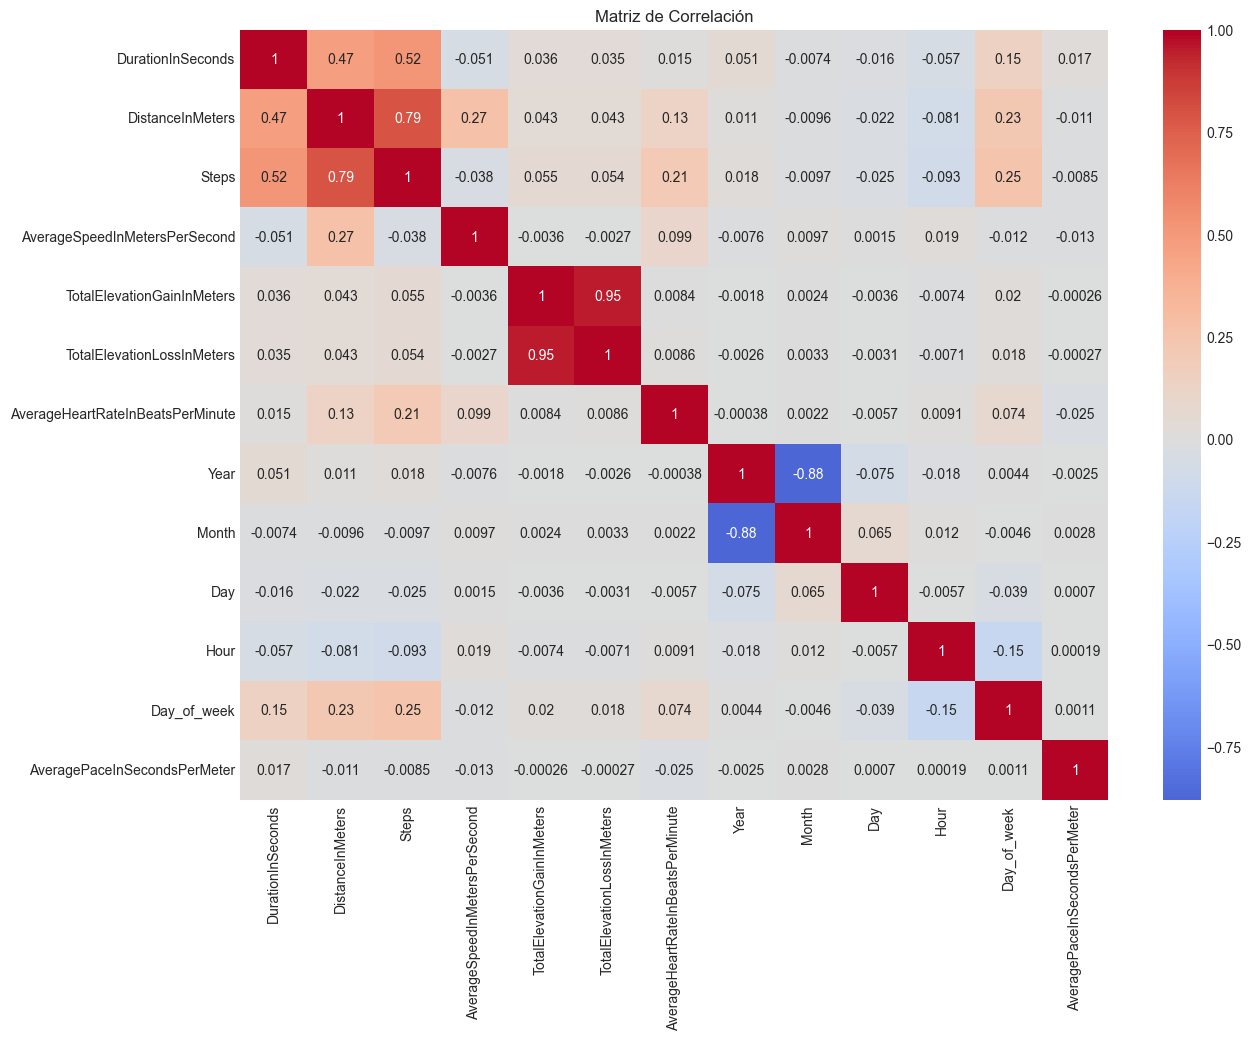

In [21]:
# Crear matriz de correlación
corr_matrix = df_numericas.corr()

# Heatmap de la matriz de correlacion
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()


En la matriz de confusión se puede observar un alta correlación positiva entre las variables Steps y DistancesInMeters por lo que se puede apreciar una relación lineal. Además se ve una correlación muy alta entre las variables TotalElevationGainInMeters y TotalElevationLossInMeters, está correlación alta puede mostrar una posible colinealidad debido a que ambas representan la misma variable pero medida en perdida o ganancia por lo que se deberá realizar algún tratamiento para evitar la colinealidad. Además, también se puede observar correlación positiva pero en menor medida entre Steps y DurationInSeconds, DistanceInMeters y DurationInSeconds. Las anteriores correlaciones positivas indican que si una variable aumenta la otra también.

In [22]:
integer_columns = df.select_dtypes(include=['int64']).columns
print("Variables enteras en el dataset:", integer_columns)


Variables enteras en el dataset: Index(['DurationInSeconds'], dtype='object')


Podemos observar que la unica variable que es entera es la duración en segundos.

#### Análisis de DurationInSeconds

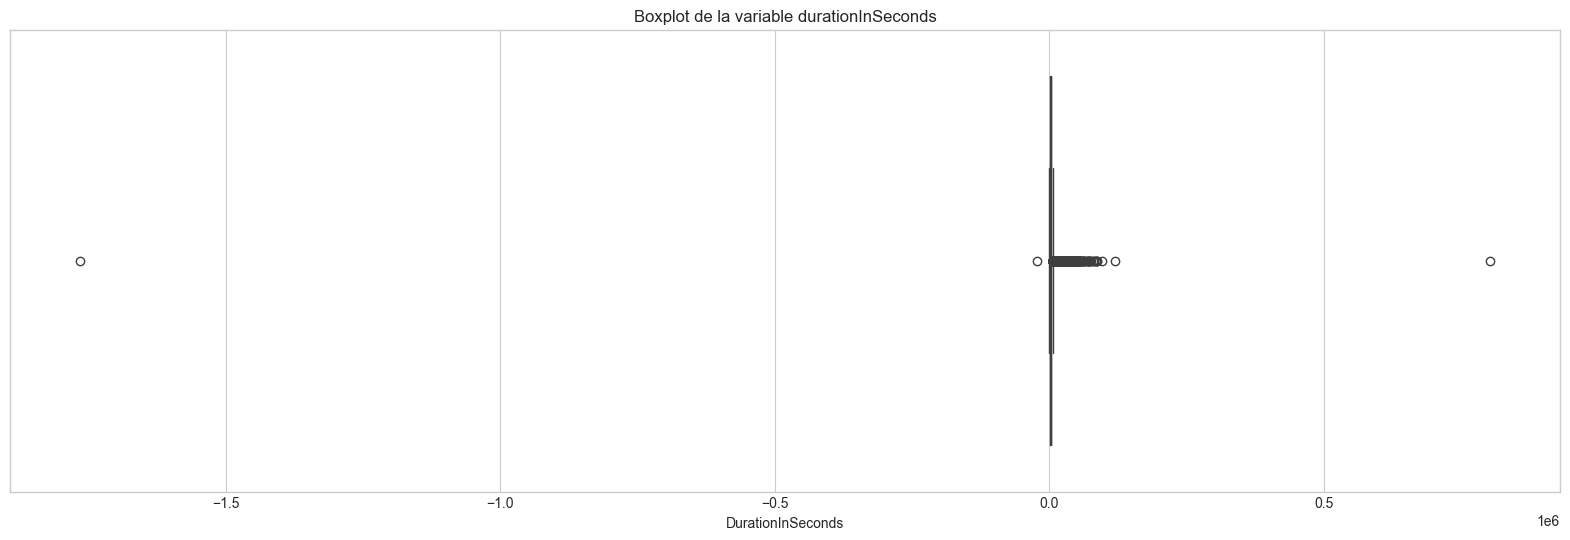

In [23]:
# Grafica de boxplot de  DurationInSeconds
plt.figure(figsize=(20, 6))
sns.boxplot(data=df, x='DurationInSeconds')
plt.title('Boxplot de la variable durationInSeconds')
plt.show()


Podemos observar que la variable de duración contiene valores negativos y valores iguales a cero. Además, se puede observar la presencia de datos atípicos que se salen de la media.

In [24]:
df['DurationInSeconds'].describe()

count    3.511950e+05
mean     2.902295e+03
std      4.155384e+03
min     -1.764163e+06
25%      1.325000e+03
50%      2.581000e+03
75%      3.763000e+03
max      8.019640e+05
Name: DurationInSeconds, dtype: float64

Tiempos nulos o negativos no tienen sentido práctico en nuestro análisis, así que se eliminarán del dataset

In [25]:
len(df[(df['DurationInSeconds']<=0)])

207

Se puede observar que se cuenta con 207 registros de duración en segundos menores o iguales a cero. Por lo que se procedera a eliminarlos:

In [26]:
# Eliminar registros con duración menos o igual a 0
df = df[(df["DurationInSeconds"] > 0)]

In [27]:
df.shape

(350988, 14)

Para facilitar el análisis inicial se eliminarán los 2 registros que superan los 100000 segundos que representan más de 27 horas continuas.

In [28]:
len(df[(df['DurationInSeconds']>100000)])

2

In [29]:
# Eliminar registros con duración menos o igual a 0
df = df[(df["DurationInSeconds"] < 100000)]

In [30]:
df.shape

(350986, 14)

In [31]:
df['DurationInSeconds'].describe()

count    350986.000000
mean       2906.486578
std        2552.759128
min           1.000000
25%        1328.000000
50%        2582.000000
75%        3764.000000
max       95739.000000
Name: DurationInSeconds, dtype: float64

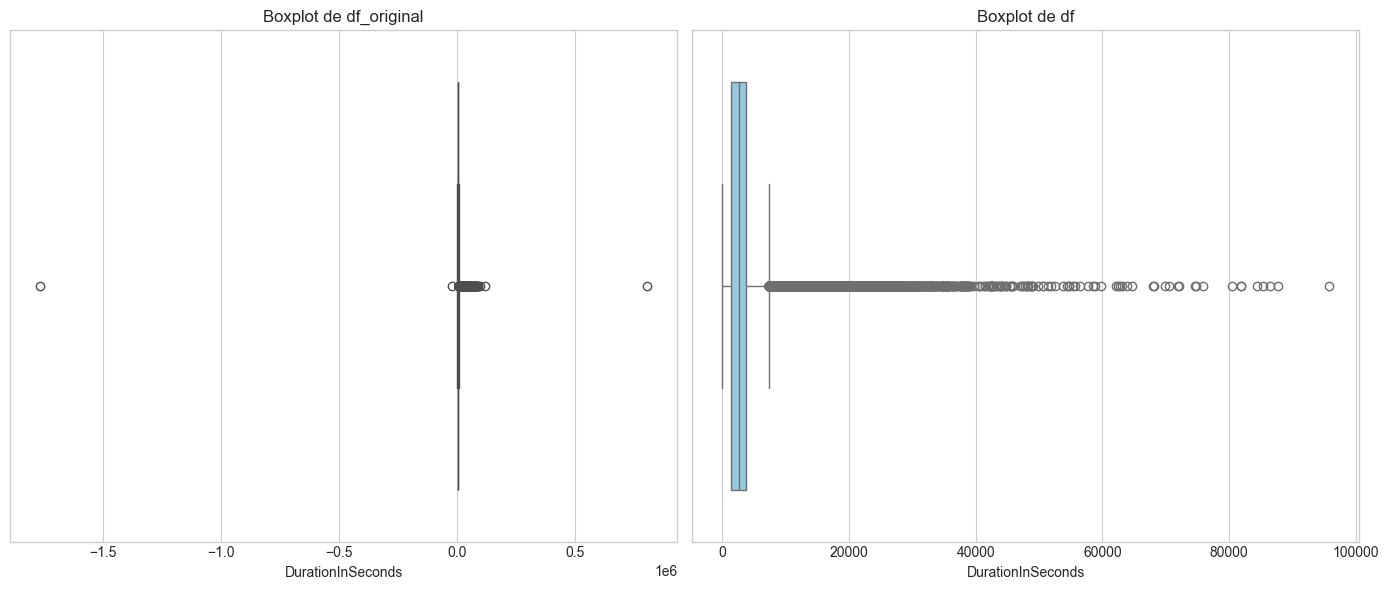

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas

sns.boxplot(data=df_original, x='DurationInSeconds', color='orange', ax=axes[0])
axes[0].set_title('Boxplot de df_original')

sns.boxplot(data=df, x='DurationInSeconds', color='skyblue', ax=axes[1])
axes[1].set_title('Boxplot de df')

plt.tight_layout()
plt.show()

En el gráfico podemos observar que parece que hay muchos valores atípicos pero esto se debe a que una gran cantidad de registros tiene una duración muy corta.

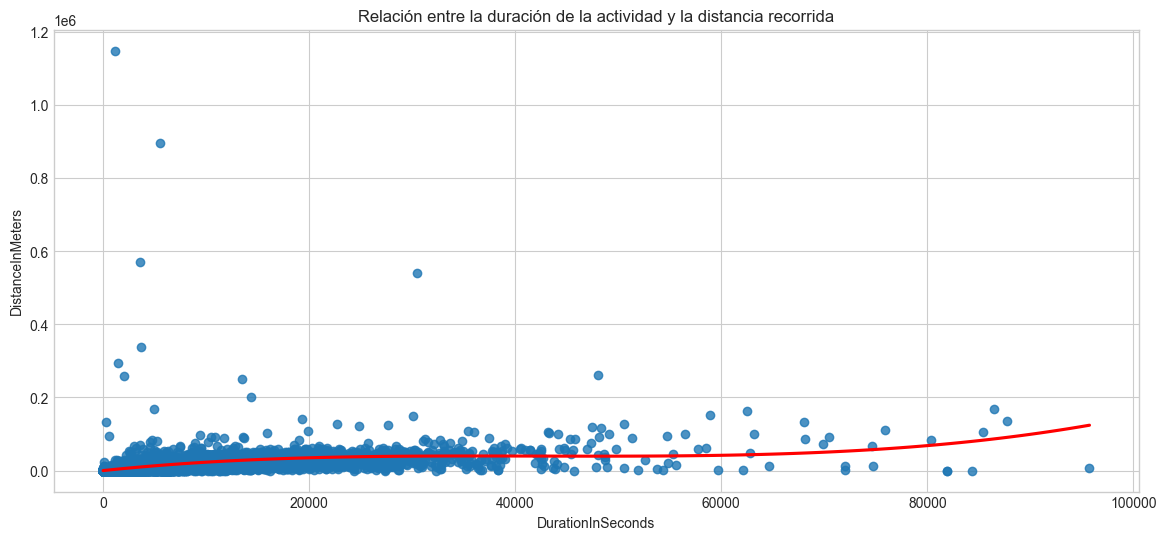

In [33]:
# Relación entre la duración de la actividad y la distancia recorrida con linea de regresion cuadratica
plt.figure(figsize=(14, 6))
sns.regplot(data=df, x='DurationInSeconds', y='DistanceInMeters', order=3, ci=None, line_kws={'color':'red'})
plt.title('Relación entre la duración de la actividad y la distancia recorrida')
plt.show()

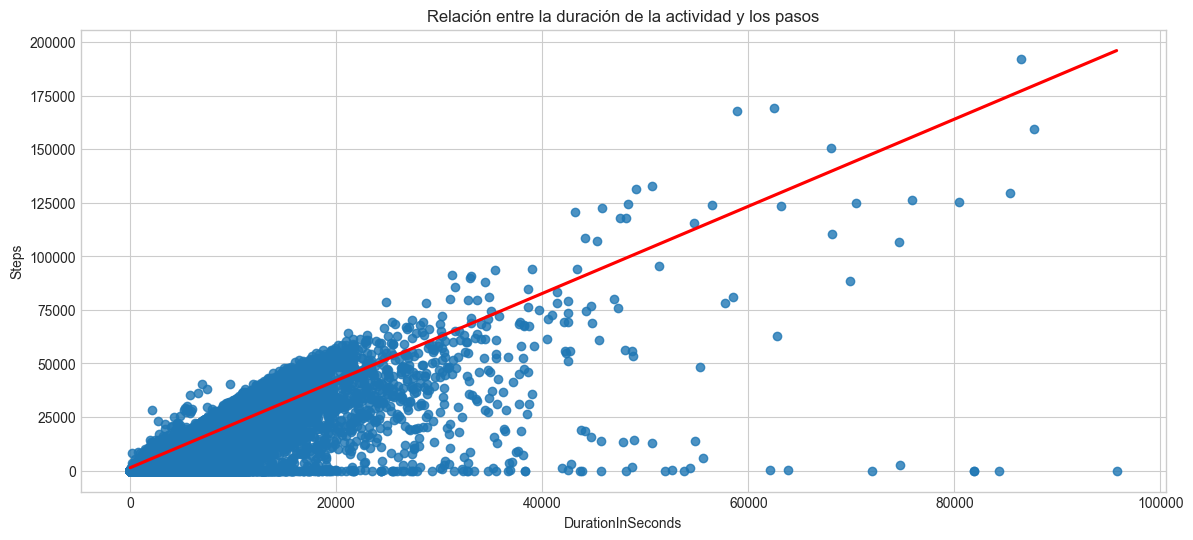

In [34]:
plt.figure(figsize=(14, 6))
sns.regplot(data=df, x='DurationInSeconds', y='Steps', ci=None, line_kws={'color':'red'})
plt.title('Relación entre la duración de la actividad y los pasos')
plt.show()

### Análisis de DistanceInMeters

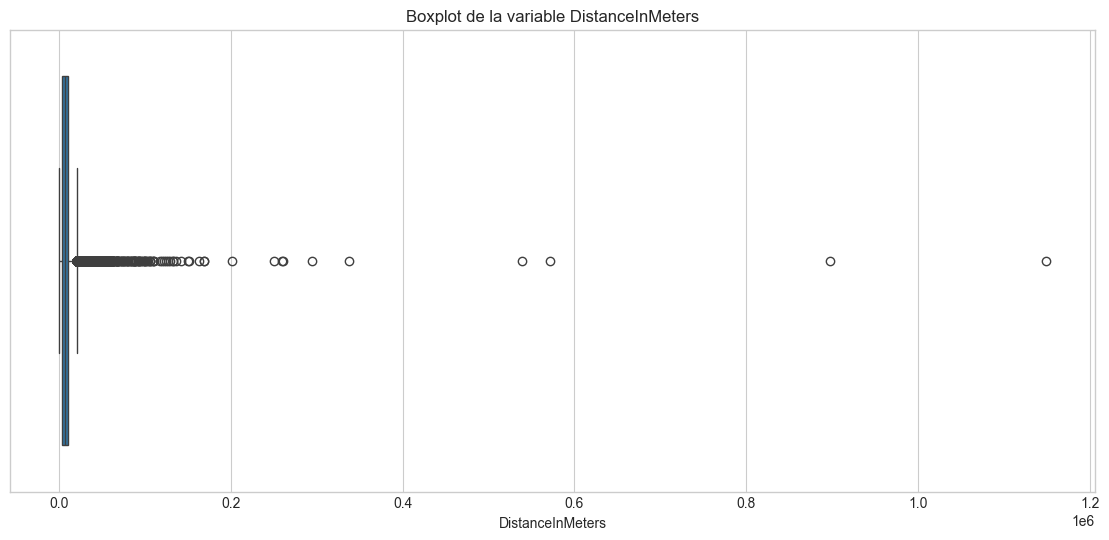

In [35]:
# Grafica de boxplot de DistanceInMeters
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='DistanceInMeters')
plt.title('Boxplot de la variable DistanceInMeters')
plt.show()

In [36]:
len(df[(df['DistanceInMeters']<=0)])

508


Esta variable tiene 508 registros menores o iguales a 0. Considerando que estamos analizando una actividad deportiva de tipo Running, registros sin distancia válida no serán útiles para el análisis

In [37]:
# Eliminar registros con distancia menor o igual a 0
df = df[(df["DistanceInMeters"] > 0)]

In [38]:
df.shape

(349589, 14)

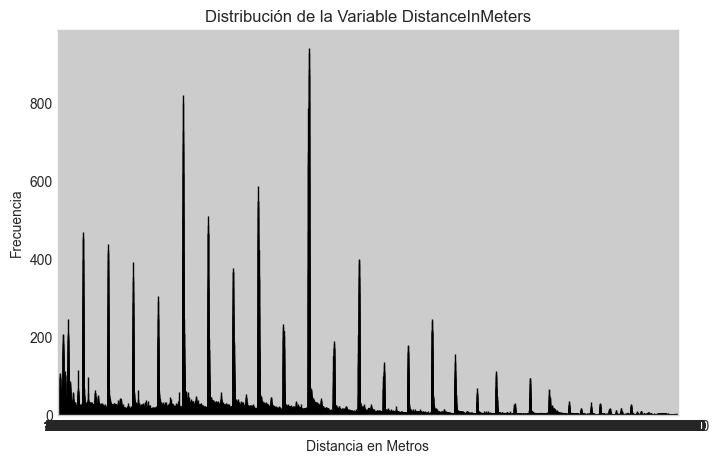

In [39]:
# Conteo de datos solo con números enteros para la variable DistanceInMeters. Esto solo con fines analíticos, no se afectará el dataset original
acumuladorDistancias = df['DistanceInMeters'].round().value_counts().sort_index()

plt.figure(figsize=(8, 5))
acumuladorDistancias.plot(kind='bar', color='skyblue', edgecolor='black')

# Personalizar etiquetas
plt.xlabel('Distancia en Metros')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Variable DistanceInMeters')
plt.xticks(rotation=0)

plt.show()

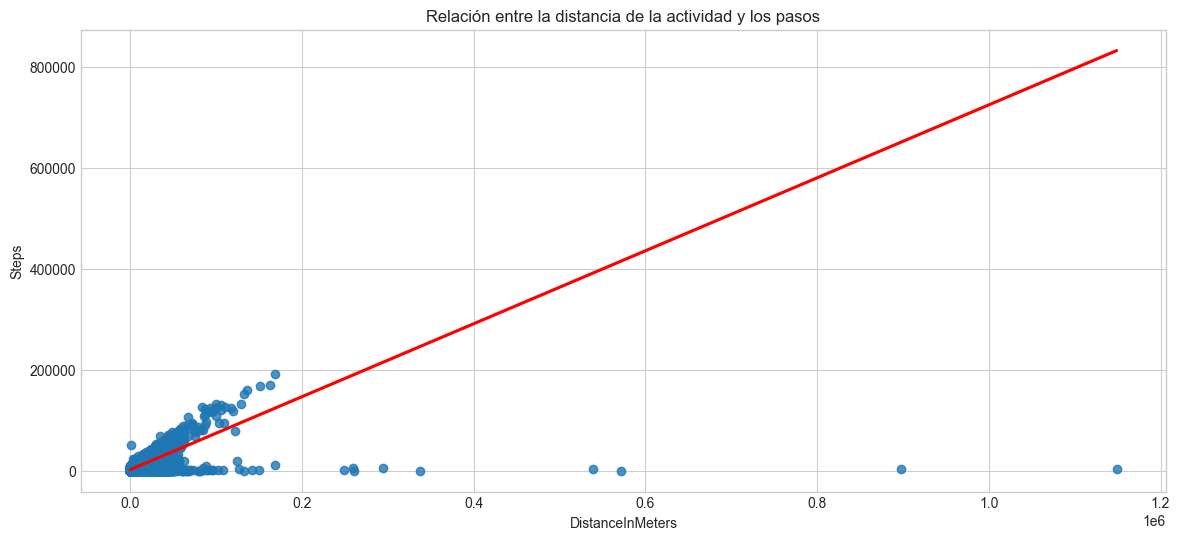

In [40]:
# Relación entre la distancia de la actividad y los pasos
plt.figure(figsize=(14, 6))
sns.regplot(data=df, x='DistanceInMeters', y='Steps', ci=None, line_kws={'color':'red'})
plt.title('Relación entre la distancia de la actividad y los pasos')
plt.show()

### Análisis de AverageSpeedInMetersPerSecond

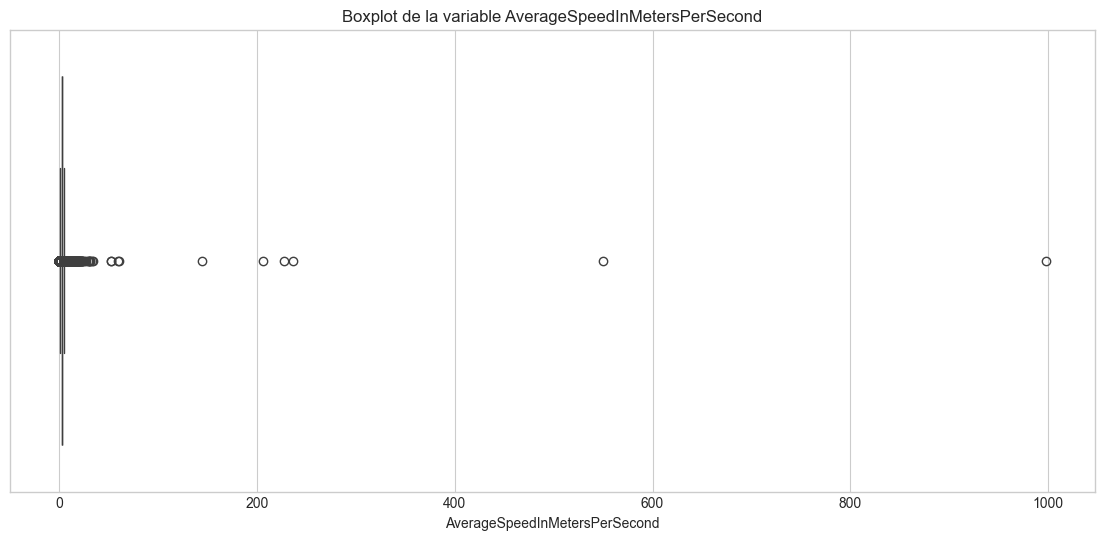

In [41]:
# Grafica de boxplot de AverageSpeedInMetersPerSecond
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='AverageSpeedInMetersPerSecond')
plt.title('Boxplot de la variable AverageSpeedInMetersPerSecond')
plt.show()

In [42]:
# Cantidad de registros con velocidad promedio menor o igual a 0
len(df[(df['AverageSpeedInMetersPerSecond']<=0)])

16

Se pueden obsevar 16 registros de velocidad menores o iguales a cero por lo que se eliminarán debido a que no tendrían validez para el análisis realizado.

In [43]:
df = df[(df["AverageSpeedInMetersPerSecond"] > 0)]

### Análisis de AveragePaceInSecondsPerMeter

In [44]:
df['AveragePaceInSecondsPerMeter'].describe()

count    349570.000000
mean          0.553504
std           9.784565
min           0.001200
25%           0.317561
50%           0.363605
75%           0.424317
max        2250.000000
Name: AveragePaceInSecondsPerMeter, dtype: float64

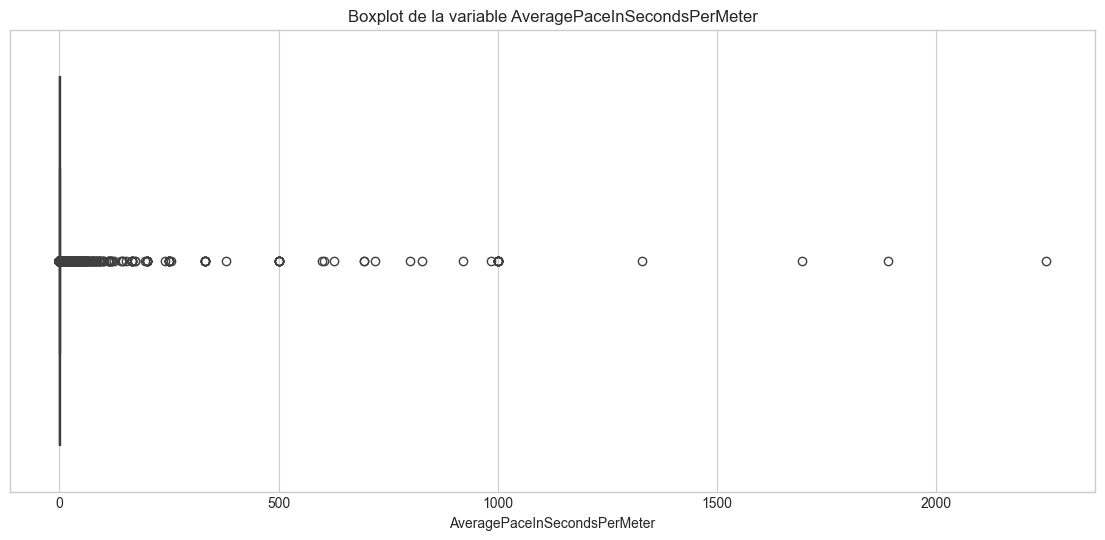

In [45]:
# Grafica de boxplot de AveragePaceInSecondsPerMeter
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='AveragePaceInSecondsPerMeter')
plt.title('Boxplot de la variable AveragePaceInSecondsPerMeter')
plt.show()

Para el caso del ritmo los valores atípicos se observan de dos formas, la primera cuando el ritmo es muy bajo debido a que entre menor sea el ritmo significa que la persona corre más rapido; por otro lado si el ritmo es muy alto significa que la persona esta caminando o esta en reposo.

In [46]:
# Cantidad de registros con ritmo promedio menor o igual a 0
len(df[(df['AveragePaceInSecondsPerMeter']<=0)])

0

### Análisis de TotalElevationGainInMeters y TotalElevationLossInMeters

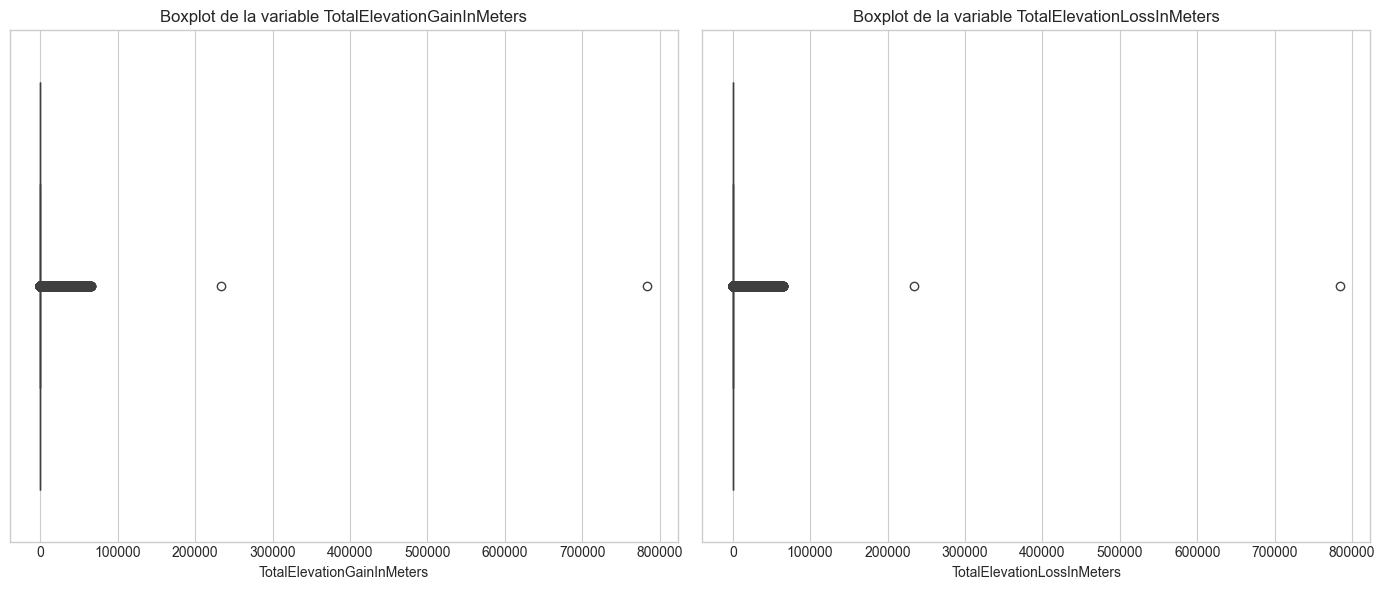

In [47]:
# Crear una figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grafica de boxplot de TotalElevationGainInMeters
sns.boxplot(data=df, x='TotalElevationGainInMeters', ax=axes[0])
axes[0].set_title('Boxplot de la variable TotalElevationGainInMeters')

# Grafica de boxplot de TotalElevationLossInMeters
sns.boxplot(data=df, x='TotalElevationLossInMeters', ax=axes[1])
axes[1].set_title('Boxplot de la variable TotalElevationLossInMeters')

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

Eliminar los 2 outliers que entorpecen el entendimiento de las variables TotalElevationGainInMeters y TotalElevationLossInMeters

In [48]:
print(len(df[(df["TotalElevationGainInMeters"] > 100000)]))
print(len(df[(df["TotalElevationLossInMeters"] > 100000)]))

2
2


In [49]:
df = df[~((df["TotalElevationGainInMeters"] > 100000) | (df["TotalElevationLossInMeters"] > 100000))]

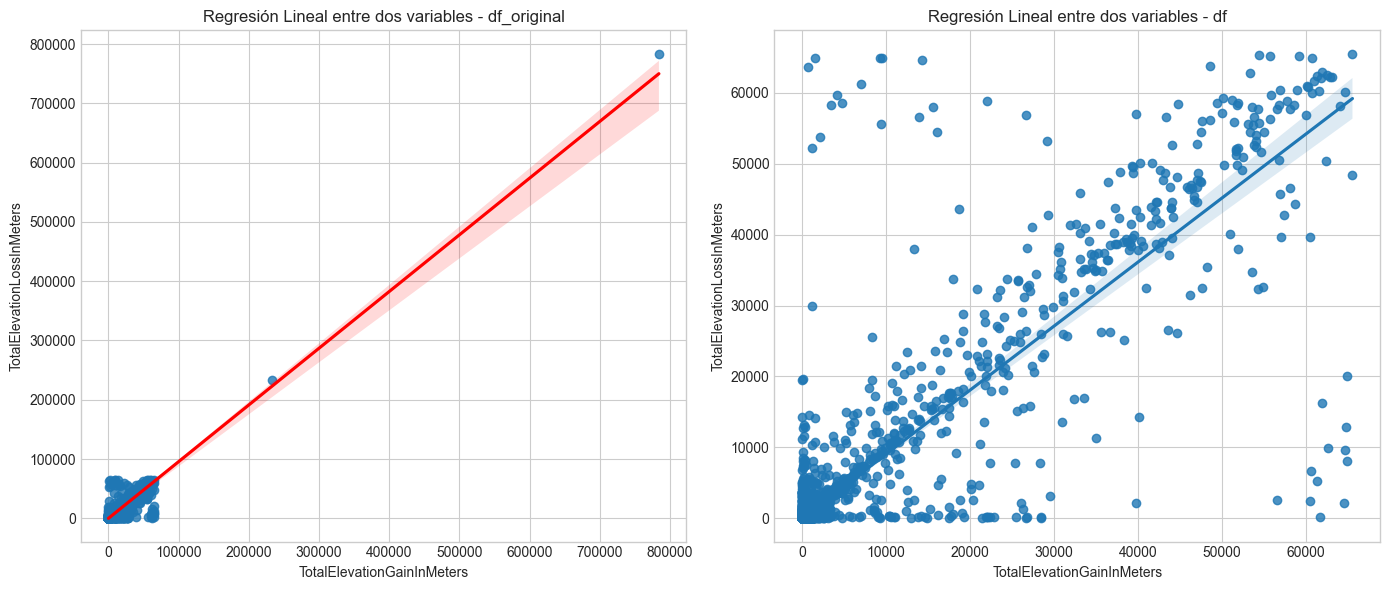

In [50]:
# Se analizará TotalElevationGainInMeters y TotalElevationLossInMeters debido a que presentan una correlación muy alta

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.regplot(x=df_original["TotalElevationGainInMeters"], y=df_original["TotalElevationLossInMeters"], ax=axes[0], line_kws={'color':'red'})
axes[0].set_title('Regresión Lineal entre dos variables - df_original')

sns.regplot(x=df["TotalElevationGainInMeters"], y=df["TotalElevationLossInMeters"], ax=axes[1])
axes[1].set_title('Regresión Lineal entre dos variables - df')
plt.tight_layout()
plt.show()

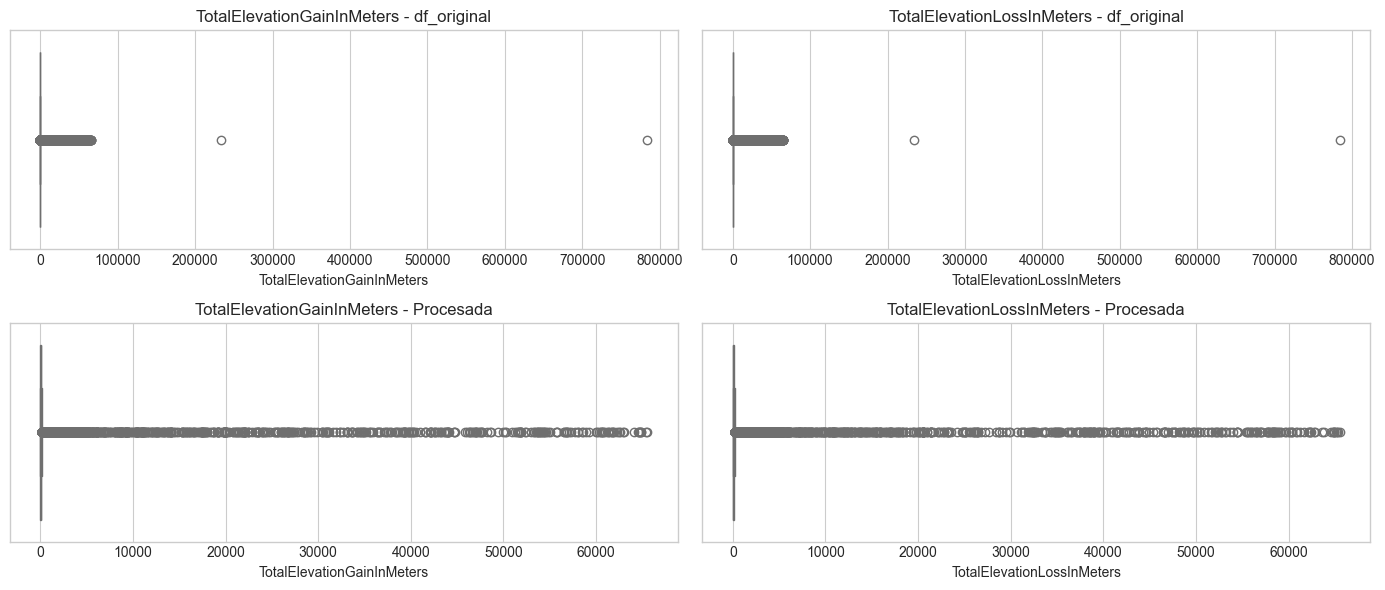

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
sns.boxplot(data=df_original, x='TotalElevationGainInMeters', color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('TotalElevationGainInMeters - df_original')

sns.boxplot(data=df_original, x='TotalElevationLossInMeters', color='skyblue', ax=axes[0, 1])
axes[0, 1].set_title('TotalElevationLossInMeters - df_original')

sns.boxplot(data=df, x='TotalElevationGainInMeters', color='skyblue', ax=axes[1, 0])
axes[1, 0].set_title('TotalElevationGainInMeters - Procesada')

sns.boxplot(data=df, x='TotalElevationLossInMeters', color='skyblue', ax=axes[1, 1])
axes[1, 1].set_title('TotalElevationLossInMeters - Procesada')

plt.tight_layout()
plt.show()

In [52]:
df['TotalElevationGainInMeters'].describe()

count    317245.000000
mean        127.766113
std        1319.214961
min           0.000000
25%          11.327793
50%          32.380000
75%          82.270000
max       65513.100000
Name: TotalElevationGainInMeters, dtype: float64

Debido a que las variables manejadas individualmente tiene un alto porcentaje de nulos:
TotalElevationGainInMeters: 33316 registros nulos
TotalElevationLossInMeters: 32925 registros nulos
Y se consideran importantes para el sistema de detección, se hace una transformación clasificando el terreno recorrido por el usuario como:
- **Flat**: Si TotalElevationGainInMeters y TotalElevationLossInMeters son 0 o nulos
- **Uphill**: Si TotalElevationGainInMeters es mayor a 0 y TotalElevationLossInMeters es 0
- **Downhill**: Si TotalElevationGainInMeters es 0 y TotalElevationLossInMeters es mayor a 0
- **Mixed**: Si TotalElevationGainInMeters y TotalElevationLossInMeters son mayores a 0

In [53]:
# Debido a que se observa un alta correlación entre ambas variables lo que nos indica que si se usan como predictoras para el modelo podemos tener problemas de colinealidad
"""
Se considera que la variable TotalElevationGainInMeters y TotalElevationLossInMeters aportan información relevante para el análisis,
por tanto se computará una columna adicional que represente el tipo de terreno en el cual se realizó la actividad
    1. Flat: Si TotalElevationGainInMeters y TotalElevationLossInMeters son 0 o nulos
    2. Uphill: Si TotalElevationGainInMeters es mayor a 0 y TotalElevationLossInMeters es 0
    3. Downhill: Si TotalElevationGainInMeters es 0 y TotalElevationLossInMeters es mayor a 0
    4. Mixed: Si TotalElevationGainInMeters y TotalElevationLossInMeters son mayores a 0
"""
df['TerrainType'] = 'Flat'  # Initialize with 'Flat'
df.loc[(df['TotalElevationGainInMeters'] > 0) & (df['TotalElevationLossInMeters'] == 0), 'TerrainType'] = 'Uphill'
df.loc[(df['TotalElevationGainInMeters'] == 0) & (df['TotalElevationLossInMeters'] > 0), 'TerrainType'] = 'Downhill'
df.loc[(df['TotalElevationGainInMeters'] > 0) & (df['TotalElevationLossInMeters'] > 0), 'TerrainType'] = 'Mixed'


# Eliminar las variables usadas para crear TerrainType
df = df.drop('TotalElevationGainInMeters', axis=1)
df = df.drop('TotalElevationLossInMeters', axis=1)

In [54]:
df.head()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,SourceType,Year,Month,Day,Hour,Day_of_week,AveragePaceInSecondsPerMeter,TerrainType
0,2308,6050.10,6802.0,2.622,145.0,Garmin,2024,9,30,20,0,0.381388,Mixed
1,232,557.72,600.0,2.399,91.0,Garmin,2024,9,30,23,0,0.416840,Flat
2,320,770.48,856.0,2.407,114.0,Garmin,2024,9,30,23,0,0.415455,Mixed
3,1895,5005.62,5254.0,2.642,146.0,Garmin,2024,9,30,23,0,0.378501,Mixed
4,4386,10376.22,11452.0,2.365,143.0,Garmin,2024,9,30,21,0,0.422833,Mixed


DistanceInMeters                                            \
                       count         mean          std   min       25%   
TerrainType                                                              
Downhill              2437.0  4430.399695  3717.051023  2.00  1320.660   
Flat                 50815.0  2994.651074  6703.320893  0.01   398.920   
Mixed               294222.0  8447.166290  6337.599695  2.61  4873.040   
Uphill                2094.0  5605.947732  5177.965245  3.00  1623.725   

                                              DurationInSeconds               \
                  50%         75%         max             count         mean   
TerrainType                                                                    
Downhill     3466.650   6509.4900    25013.00            2437.0  1677.442347   
Flat         1088.520   4180.0000  1148765.00           50815.0  1201.578195   
Mixed        7510.035  10598.1650   897198.75          294222.0  3222.790403   
Uphill       4917.130   8140.1025    67343.49            2094.0  2169.064470   

             ... AverageSpeedInMetersPerSecond              \
             ...                           75%         max   
TerrainType  ...                                             
Downhill     ...                         3.177    8.173000   
Flat         ...                         3.690  997.690002   
Mixed        ...                         3.106  549.888000   
Uphill       ...                         3.063   14.273000   

            AverageHeartRateInBeatsPerMinute                              \
                                       count        mean        std  min   
TerrainType                                                                
Downhill                              2429.0  138.095513  25.156379  0.0   
Flat                                 46991.0  126.366943  41.522049  0.0   
Mixed                               285259.0  143.370740  19.623695  0.0   
Uphill                                2074.0  134.185632  38.320830  0.0   

                                         
               25%    50%    75%    max  
TerrainType                              
Downhill     127.0  141.0  153.0  186.0  
Flat         119.0  137.0  150.0  239.0  
Mixed        134.0  145.0  156.0  232.0  
Uphill       127.0  144.0  155.0  198.0  

[4 rows x 32 columns]

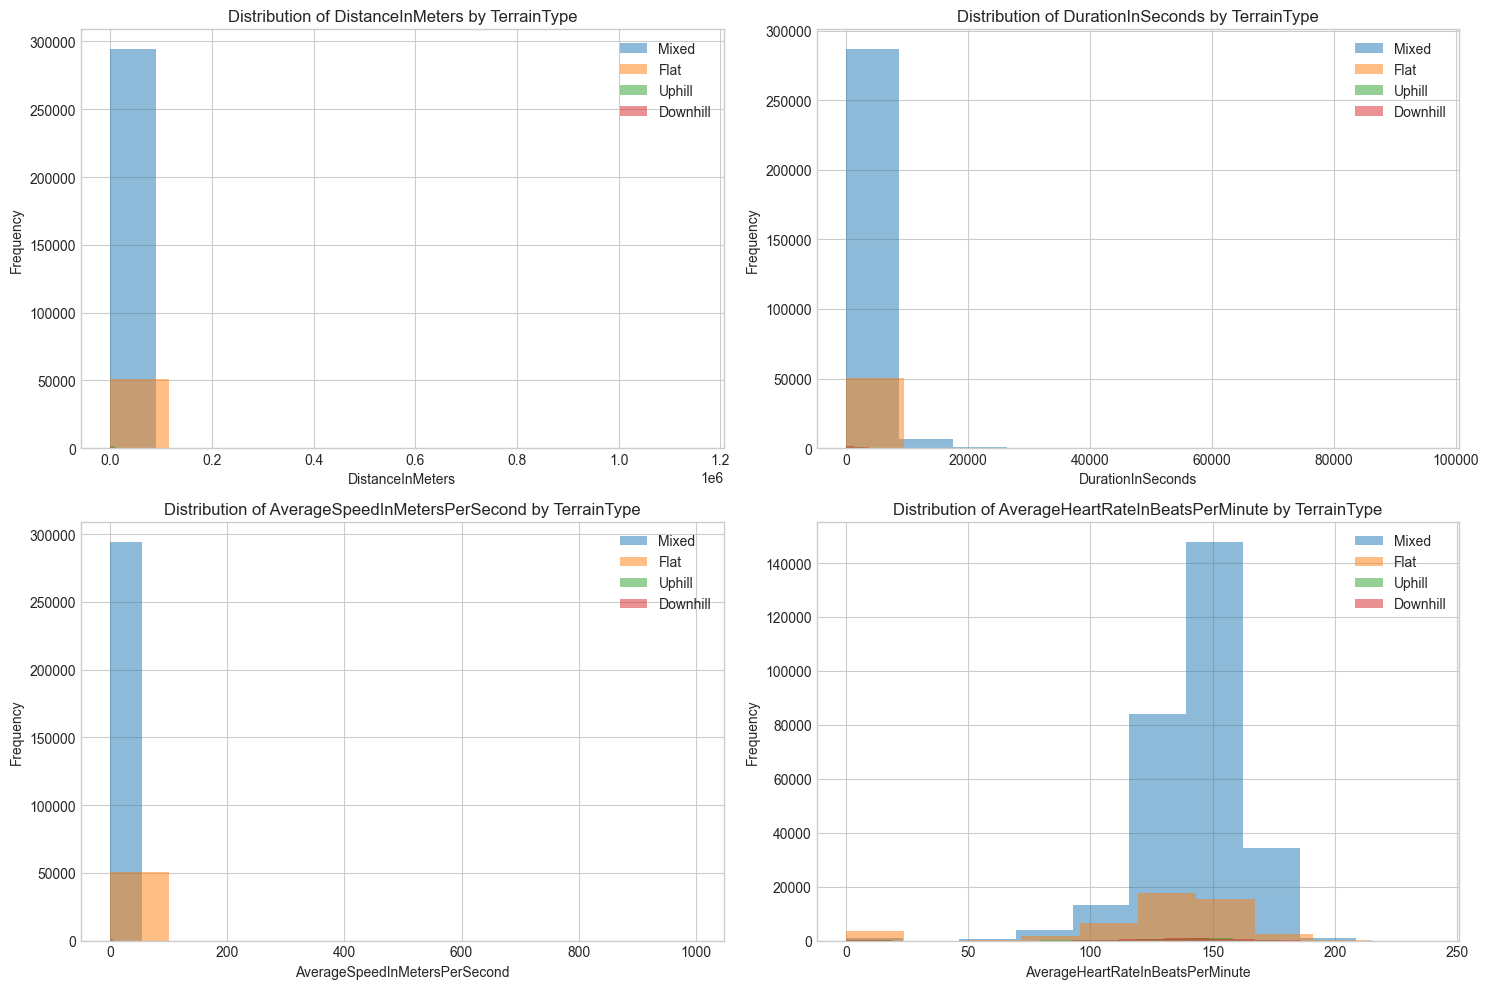

In [55]:
# Numerical variables to analyze
numerical_cols = ['DistanceInMeters', 'DurationInSeconds', 'AverageSpeedInMetersPerSecond', 'AverageHeartRateInBeatsPerMinute']

# 1. Descriptive statistics grouped by TerrainType
descriptive_stats = df.groupby('TerrainType')[numerical_cols].describe()
display(descriptive_stats)

# 2. Visualize distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    for terrain_type in df['TerrainType'].unique():
        plt.hist(df[df['TerrainType'] == terrain_type][col].dropna(), alpha=0.5, label=terrain_type)
    plt.title(f'Distribution of {col} by TerrainType')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()


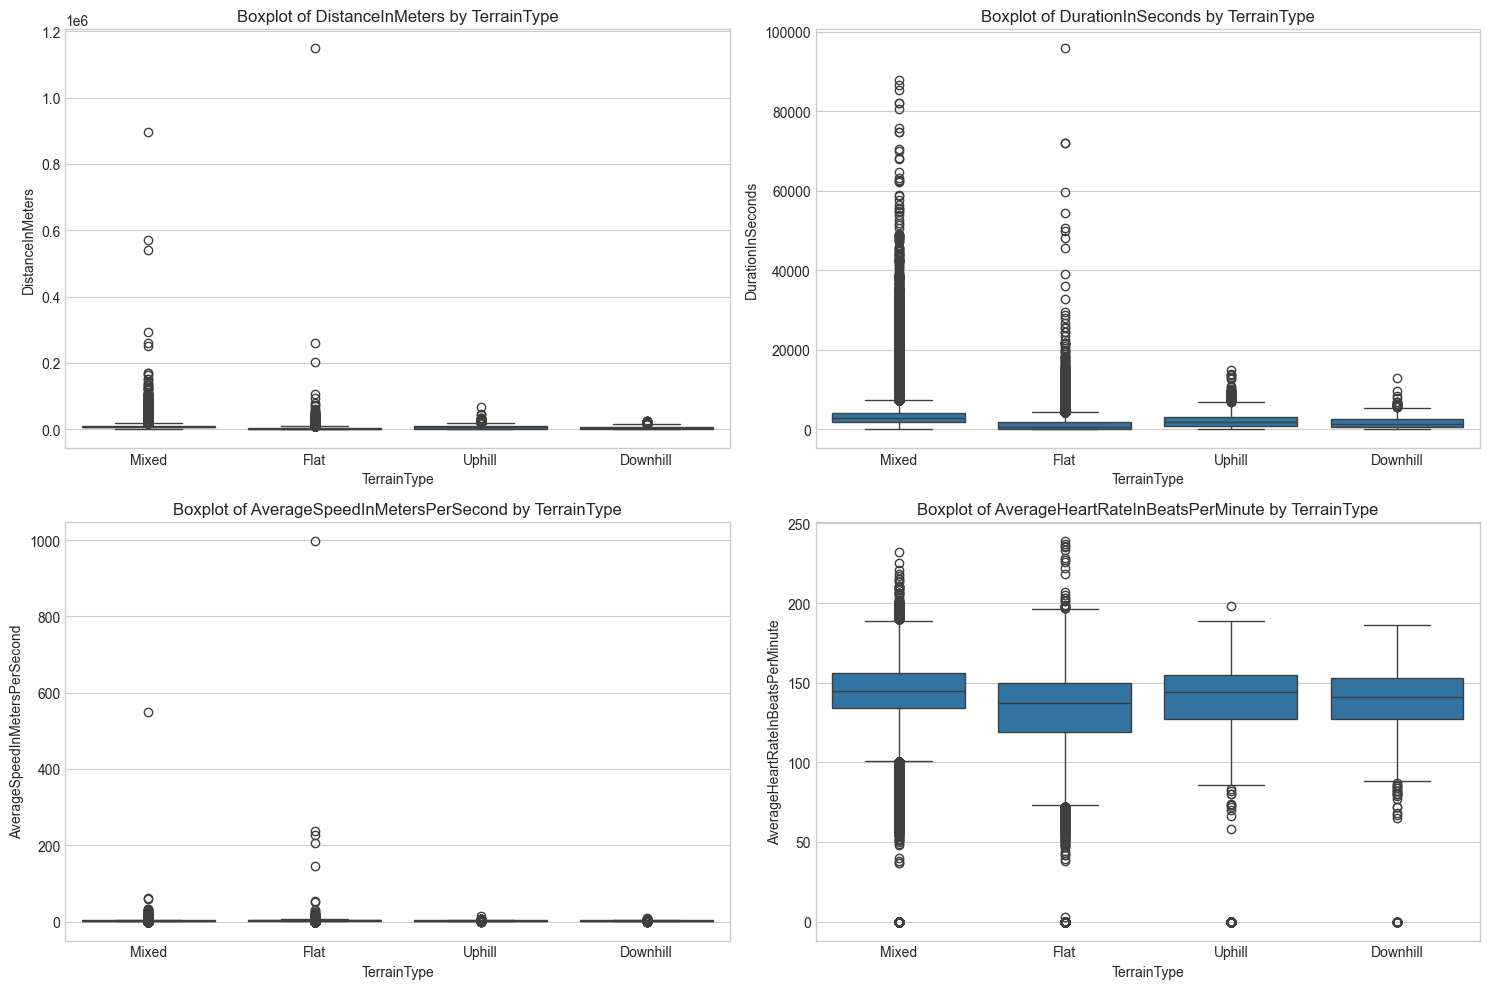

In [56]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='TerrainType', y=col, data=df)
    plt.title(f'Boxplot of {col} by TerrainType')
plt.tight_layout()
plt.show()


En los Boxplot se evidencia que con la clasificación de TerrainType en 4 categorías: Flat, Uphill, Downhill y Mixed, se observa que los terrenos Mixed y Flat presentan una mayor probabilidad de contener datos atípicos en cada una de las variables.

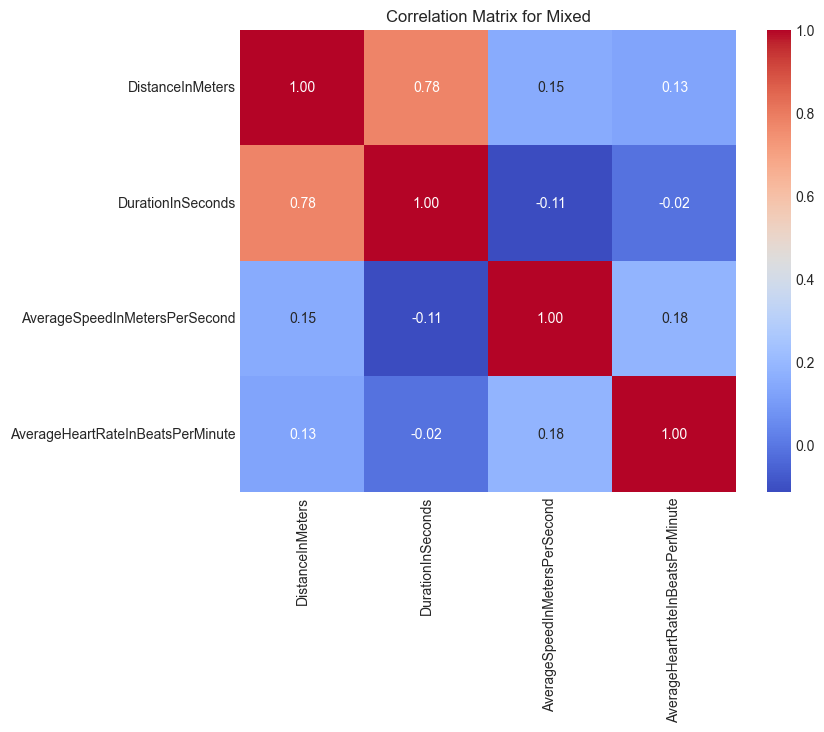

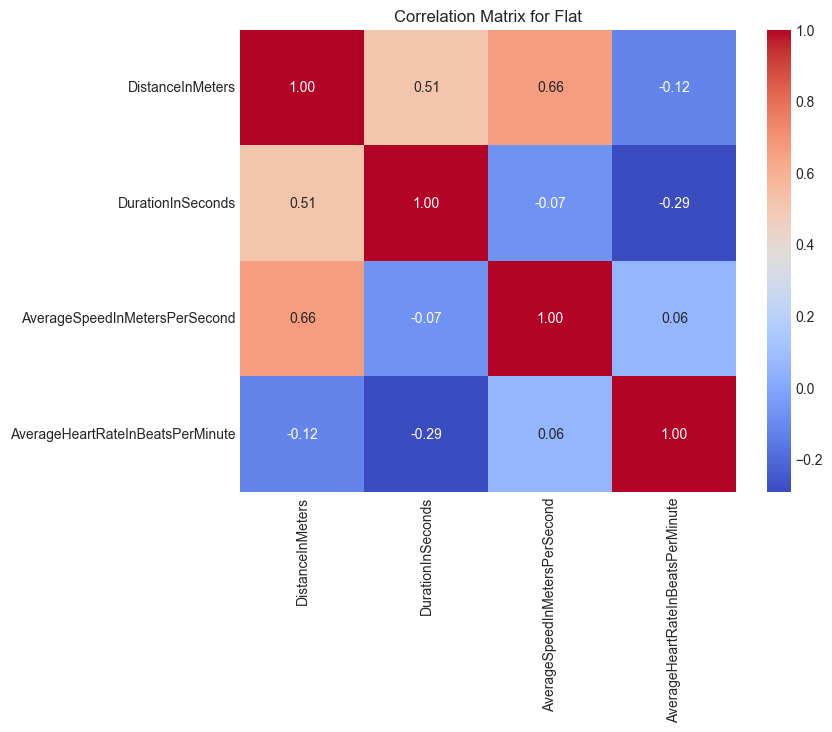

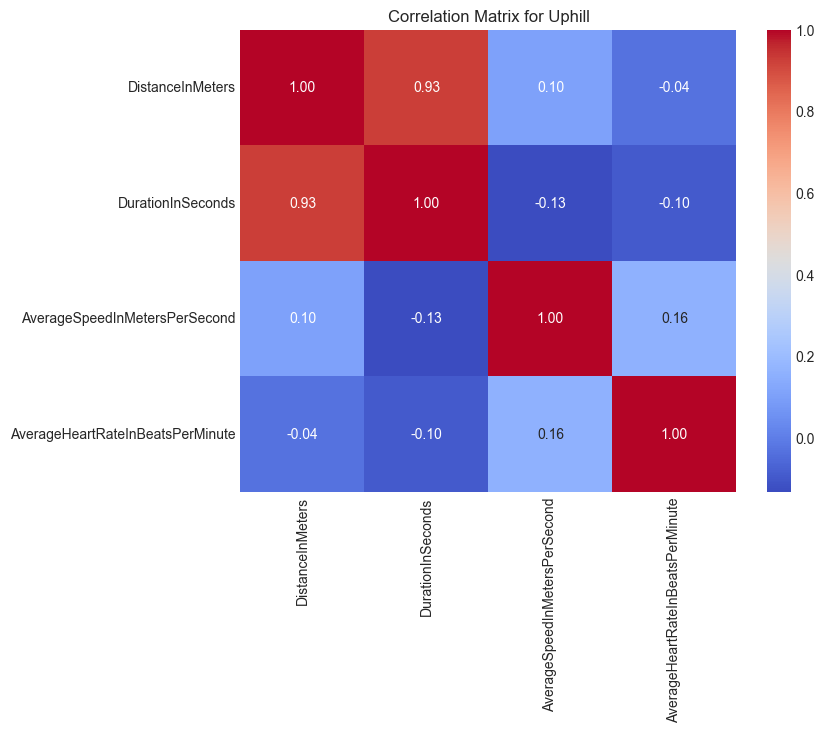

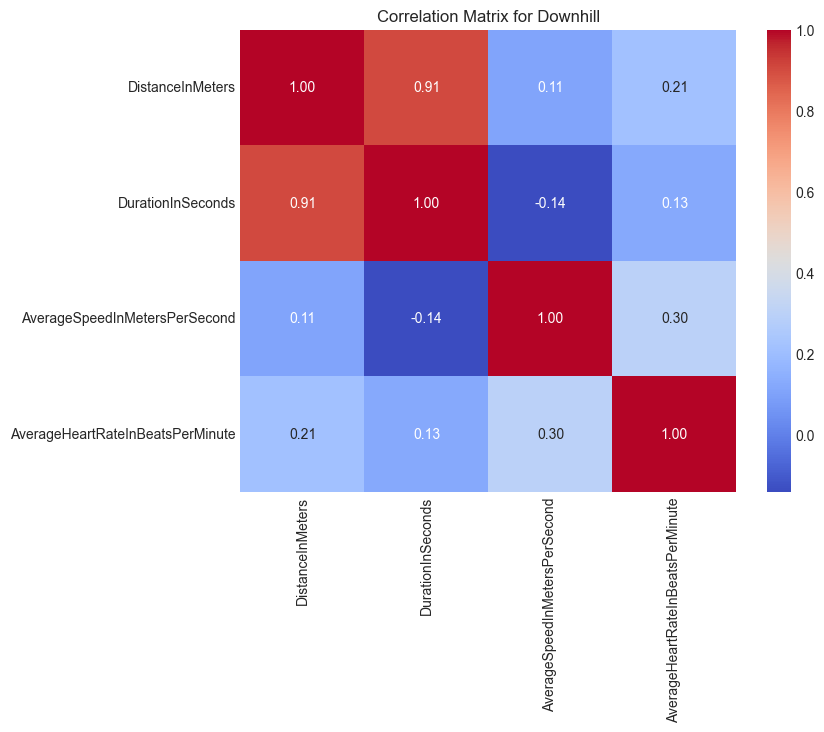

In [57]:
# 3. Correlation matrices and heatmaps
for terrain_type in df['TerrainType'].unique():
    terrain_data = df[df['TerrainType'] == terrain_type]
    correlation_matrix = terrain_data[numerical_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix for {terrain_type}')
    plt.show()

### Análisis de AverageHeartRateInBeatsPerMinute

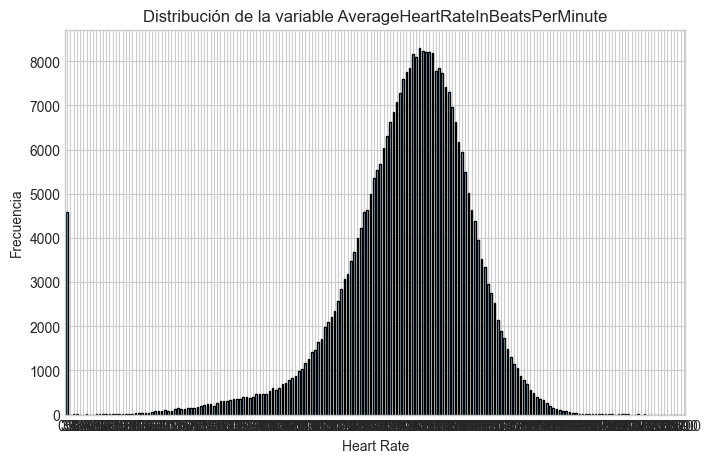

In [58]:
# Contenteo de datos solo con números enteros para la variable AverageHeartRateInBeatsPerMinute. Esto solo con fines analíticos, no se afectará el dataset original
acumuladoRate = df['AverageHeartRateInBeatsPerMinute'].round().value_counts().sort_index()

plt.figure(figsize=(8, 5))
acumuladoRate.plot(kind='bar', color='skyblue', edgecolor='black')

# Personalizar etiquetas
plt.xlabel('Heart Rate')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable AverageHeartRateInBeatsPerMinute')
plt.xticks(rotation=0)

plt.show()

In [59]:
len(df[(df['AverageHeartRateInBeatsPerMinute']==0)])

4599

In [60]:
df_encoded = pd.get_dummies(df, columns=['TerrainType','SourceType'])
df_encoded.head()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week,...,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill,SourceType_Apple,SourceType_Coros,SourceType_Garmin,SourceType_Polar,SourceType_Suunto,SourceType_Wahoo
0,2308,6050.10,6802.0,2.622,145.0,2024,9,30,20,0,...,False,False,True,False,False,False,True,False,False,False
1,232,557.72,600.0,2.399,91.0,2024,9,30,23,0,...,False,True,False,False,False,False,True,False,False,False
2,320,770.48,856.0,2.407,114.0,2024,9,30,23,0,...,False,False,True,False,False,False,True,False,False,False
3,1895,5005.62,5254.0,2.642,146.0,2024,9,30,23,0,...,False,False,True,False,False,False,True,False,False,False
4,4386,10376.22,11452.0,2.365,143.0,2024,9,30,21,0,...,False,False,True,False,False,False,True,False,False,False


In [61]:
columnas_para_imputacion = [
    'DurationInSeconds',
    'DistanceInMeters',
    'Steps',
    'AverageSpeedInMetersPerSecond',
    'Day',
    'TerrainType_Downhill',
    'TerrainType_Flat',
    'TerrainType_Mixed',
    'TerrainType_Uphill',
    'AverageHeartRateInBeatsPerMinute'
]

df_encoded['AverageHeartRateInBeatsPerMinute'] = df_encoded['AverageHeartRateInBeatsPerMinute'].replace(0, np.nan)
df_encoded['Steps'] = df_encoded['Steps'].replace(0, np.nan)
imputer = KNNImputer(n_neighbors=3)
df_encoded[columnas_para_imputacion] = imputer.fit_transform(df_encoded[columnas_para_imputacion])
df_encoded.describe()


,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week,AveragePaceInSecondsPerMeter,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill
count,349568.000000,3.495680e+05,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000
mean,2911.891197,7.609538e+03,7618.995207,2.779781,142.723866,2024.382804,7.154282,15.286408,13.574781,3.099202,0.553501,0.006971,0.145365,0.841673,0.005990
std,2545.247933,6.661491e+03,6028.627179,2.213357,18.478585,0.537406,4.683460,8.694830,5.780966,1.949200,9.784593,0.083204,0.352469,0.365048,0.077165
min,1.000000,1.000000e-02,1.000000,0.001000,3.000000,2011.000000,1.000000,1.000000,0.000000,0.000000,0.001200,0.000000,0.000000,0.000000,0.000000
25%,1340.750000,3.310995e+03,3428.000000,2.360000,133.000000,2024.000000,2.000000,8.000000,10.000000,1.000000,0.317561,0.000000,0.000000,1.000000,0.000000
50%,2587.000000,6.725620e+03,6848.000000,2.752000,145.000000,2024.000000,10.000000,15.000000,12.000000,3.000000,0.363601,0.000000,0.000000,1.000000,0.000000
75%,3767.000000,1.009703e+04,10260.000000,3.150000,155.000000,2025.000000,11.000000,22.000000,18.000000,5.000000,0.424310,0.000000,0.000000,1.000000,0.000000
max,95739.000000,1.148765e+06,192006.000000,997.690002,239.000000,2025.000000,12.000000,31.000000,23.000000,6.000000,2250.000000,1.000000,1.000000,1.000000,1.000000


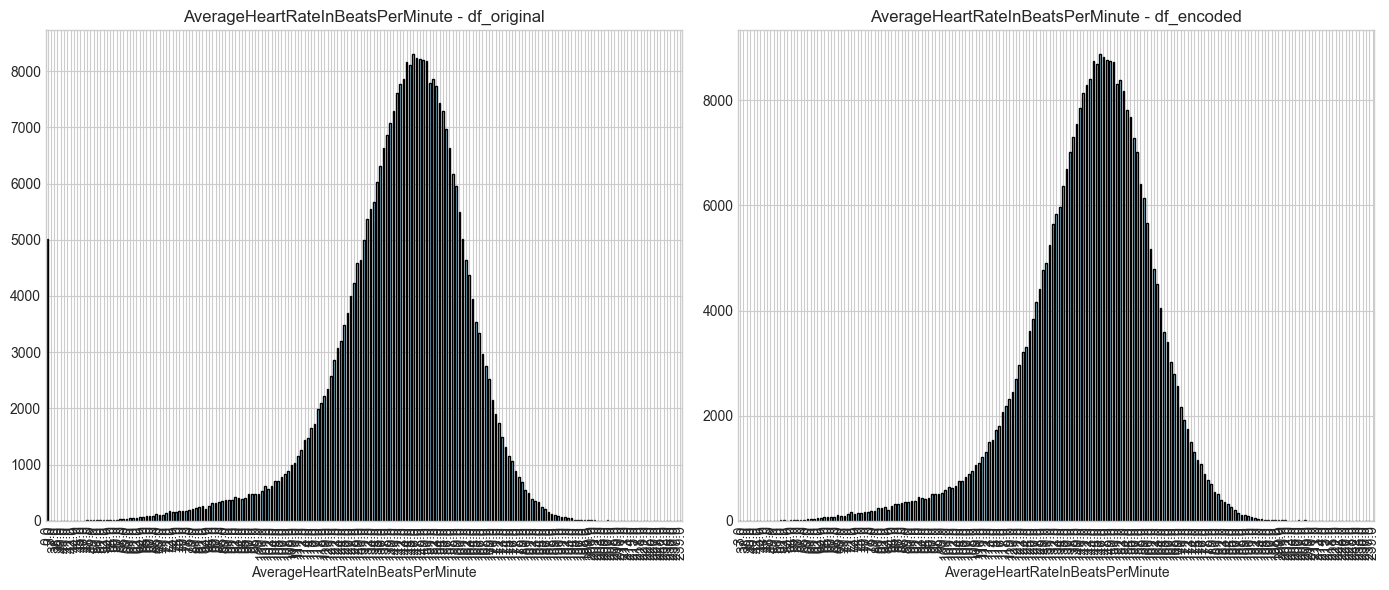

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
acumuladoRate = df_original['AverageHeartRateInBeatsPerMinute'].round().value_counts().sort_index()
acumuladoRate.plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('AverageHeartRateInBeatsPerMinute - df_original')

acumuladoRate = df_encoded['AverageHeartRateInBeatsPerMinute'].round().value_counts().sort_index()
acumuladoRate.plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[1])
axes[1].set_title('AverageHeartRateInBeatsPerMinute - df_encoded')
plt.tight_layout()
plt.show()

### Análisis de Outliers

* DistanceInMeters: Distancia recorrida durante la actividad, expresada en metros.
* AverageHeartRateInBeatsPerMinute: Frecuencia cardíaca promedio durante la actividad, medida en latidos por minuto (BPM).
* AveragePaceInMinutesPerKilometer: Ritmo promedio de la actividad, expresado en minutos por kilómetro.


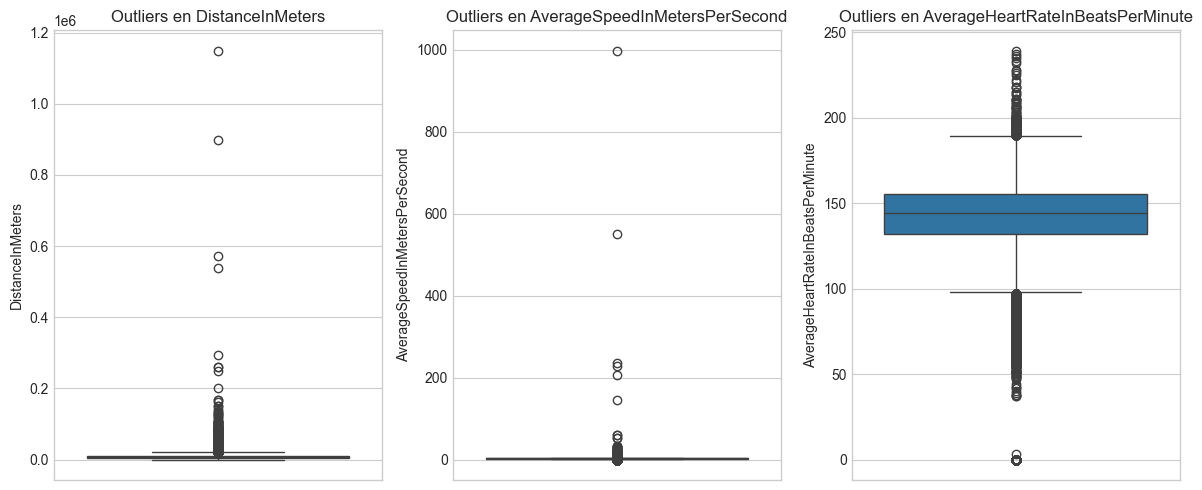

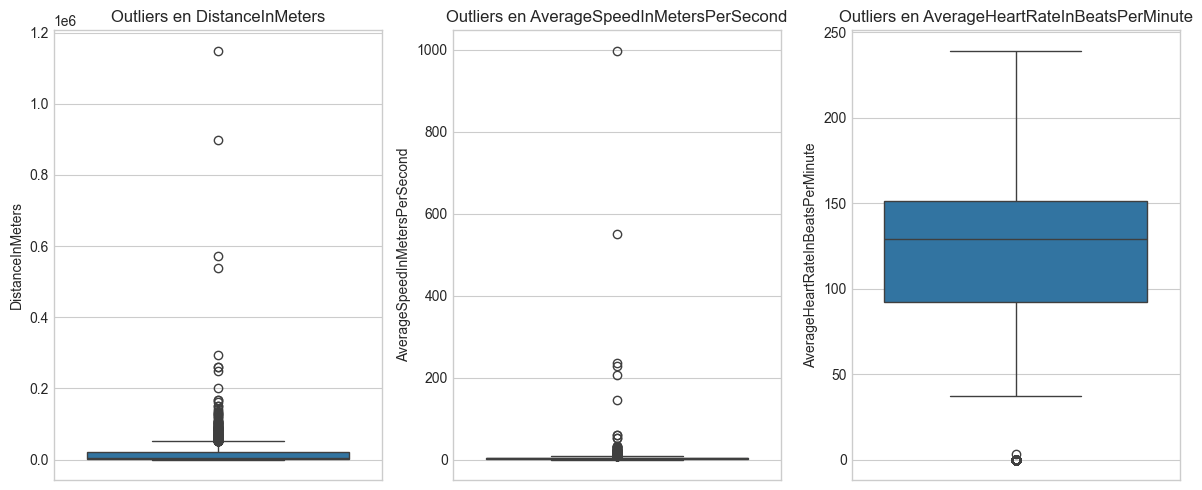

In [63]:
outlier_cols = ["DistanceInMeters", "AverageSpeedInMetersPerSecond", "AverageHeartRateInBeatsPerMinute"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Outliers en {col}")
plt.tight_layout()
plt.show()

# Detección de outliers con el método IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Crear boxplots solo con los outliers
df_outliers = pd.DataFrame()
for col in outlier_cols:
    df_outliers = pd.concat([df_outliers, detect_outliers_iqr(df, col)])

df_outliers = df_outliers.drop_duplicates()

plt.figure(figsize=(12, 5))
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df_outliers[col])
    plt.title(f"Outliers en {col}")
plt.tight_layout()
plt.show()

### Conclusiones de análisis exploratorio

1. Reveló la existencia de datos inconsistentes como valores nulos, negativos o ceros en variables como DurationInSeconds, DistanceInMeters, AverageSpeedInMetersPerSecond y AverageHeartRateInBeatsPerMinute. Además, se identificaron valores atípicos (outliers) en variables como DistanceInMeters, AverageSpeedInMetersPerSecond y AverageHeartRateInBeatsPerMinute, lo que indica posibles errores de medición, actividades sospechosas

2. Se observó un desbalance significativo en la variable SourceType, donde la marca Garmin domina ampliamente como la fuente de datos. Esto podría introducir sesgos en el modelo, ya que la distribución está fuertemente inclinada hacia esta marca.

3. Se identificaron correlaciones entre diversas variables, como Steps y DistanceInMeters, TotalElevationGainInMeters y TotalElevationLossInMeters, Steps y DurationInSeconds, y DistanceInMeters y DurationInSeconds. Estas correlaciones son esperables en el contexto de actividades de running, pero es importante considerarlas durante la selección de características para el modelo, ya que la colinealidad entre variables puede afectar la precisión del modelo.

# Limpieza de datos

Al final del proceso de exploración se realizó la limpieza, transformación e imputación de los datos por lo que en la siguiente sección se enseña cómo quedó el dataset después de este proceso.

### Revisión del df resultante después del análisis de variables inicial

In [64]:
df_encoded.shape

(349568, 21)

Los datos originales eran (351195, 16), lo que quiere decir que a nivel de registros se han eliminado 1627 lo que representa el 0.46% de los datos. Y se aumentó la cantidad de columnas a 21.

In [65]:
df_encoded.describe()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week,AveragePaceInSecondsPerMeter,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill
count,349568.000000,3.495680e+05,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000,349568.000000
mean,2911.891197,7.609538e+03,7618.995207,2.779781,142.723866,2024.382804,7.154282,15.286408,13.574781,3.099202,0.553501,0.006971,0.145365,0.841673,0.005990
std,2545.247933,6.661491e+03,6028.627179,2.213357,18.478585,0.537406,4.683460,8.694830,5.780966,1.949200,9.784593,0.083204,0.352469,0.365048,0.077165
min,1.000000,1.000000e-02,1.000000,0.001000,3.000000,2011.000000,1.000000,1.000000,0.000000,0.000000,0.001200,0.000000,0.000000,0.000000,0.000000
25%,1340.750000,3.310995e+03,3428.000000,2.360000,133.000000,2024.000000,2.000000,8.000000,10.000000,1.000000,0.317561,0.000000,0.000000,1.000000,0.000000
50%,2587.000000,6.725620e+03,6848.000000,2.752000,145.000000,2024.000000,10.000000,15.000000,12.000000,3.000000,0.363601,0.000000,0.000000,1.000000,0.000000
75%,3767.000000,1.009703e+04,10260.000000,3.150000,155.000000,2025.000000,11.000000,22.000000,18.000000,5.000000,0.424310,0.000000,0.000000,1.000000,0.000000
max,95739.000000,1.148765e+06,192006.000000,997.690002,239.000000,2025.000000,12.000000,31.000000,23.000000,6.000000,2250.000000,1.000000,1.000000,1.000000,1.000000


In [66]:
df_encoded.isna().sum()

DurationInSeconds                   0
DistanceInMeters                    0
Steps                               0
AverageSpeedInMetersPerSecond       0
AverageHeartRateInBeatsPerMinute    0
Year                                0
Month                               0
Day                                 0
Hour                                0
Day_of_week                         0
AveragePaceInSecondsPerMeter        0
TerrainType_Downhill                0
TerrainType_Flat                    0
TerrainType_Mixed                   0
TerrainType_Uphill                  0
SourceType_Apple                    0
SourceType_Coros                    0
SourceType_Garmin                   0
SourceType_Polar                    0
SourceType_Suunto                   0
SourceType_Wahoo                    0
dtype: int64

Con los resultados anteriores podemos ver que el proceso de imputación no afectó la disrtibución de las variables

### Conclusiones de limpieza

La limpieza de datos, que incluyó la eliminación de registros con valores inconsistentes y outliers. Si bien se eliminaron datos, esta reducción es justificable ya que se eliminaron registros que podrían afectar negativamente el rendimiento y la precisión del modelo.

Se realizó el análisis de datos nulos y posteriormente se realizó la aplicación del modelo KNN para realizar la imputación de datos. Adicionalmente, se eliminaron columnas que no aportaban al análisis del problema o que resultaban perjudiciales para el modelo (data leakage). 

Para mejorar el análisis, se crearon variables sintéticas como TerrainType a partir de la combinación de TotalElevationGainInMeters y TotalElevationLossInMeters. Esta nueva variable permitió un análisis más completo de las características de las actividades de running y su relación con posibles anomalías.

## Estandarización

In [67]:
scaler = StandardScaler()
df_encoded_scaled = scaler.fit_transform(df_encoded) 

# Modelamiento

## Kmeans

In [68]:
df_encoded_scaled_kmeans = df_encoded_scaled.copy()
# Entrenar KMeans en todo el dataset
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(df_encoded_scaled_kmeans)

# Obtener etiquetas y centroides
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Calcular distancias y definir umbral de anomalía
distances = np.linalg.norm(df_encoded_scaled_kmeans - centers[labels, :], axis=1)
dist_threshold = np.percentile(distances, 95)

# Detectar anomalías en el dataset completo
anomalies = np.sum(distances > dist_threshold)
print('KMeans clustering detected anomalies:', anomalies)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_encoded_scaled_kmeans)

KMeans clustering detected anomalies: 17479


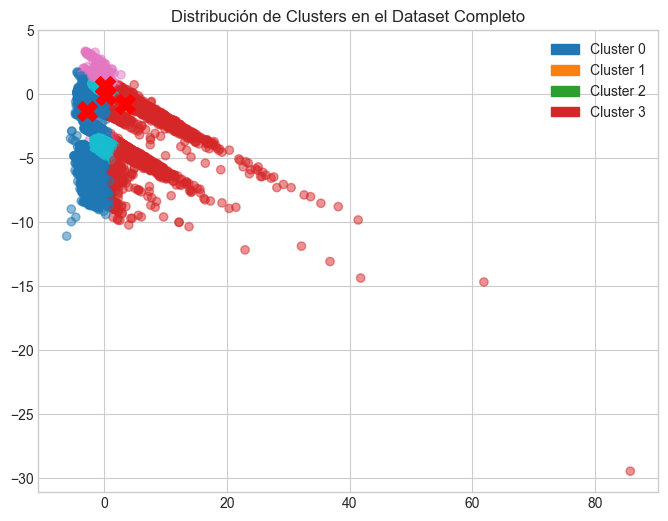

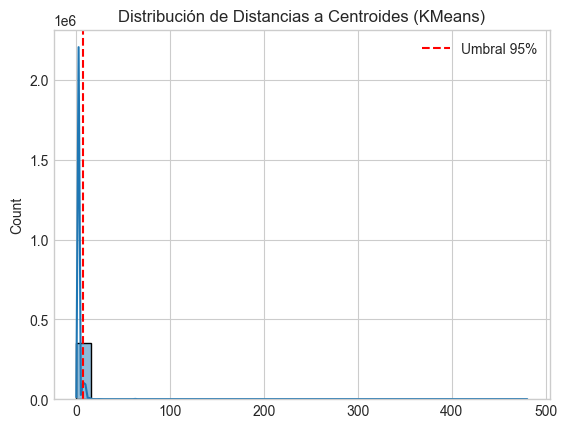

In [69]:
# Visualización de clusters
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='tab10', alpha=0.5)
plt.scatter(pca.transform(centers)[:, 0], pca.transform(centers)[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title('Distribución de Clusters en el Dataset Completo')
unique_labels = set(labels)
handles = [mpatches.Patch(color=plt.cm.tab10(i/10), label=f'Cluster {i}') for i in unique_labels]
plt.legend(handles=handles)
plt.show()

# Histograma de distancias
sns.histplot(distances, bins=30, kde=True)
plt.axvline(dist_threshold, color='red', linestyle='dashed', label='Umbral 95%')
plt.legend()
plt.title('Distribución de Distancias a Centroides (KMeans)')
plt.show()

In [78]:
# Asignar etiquetas de cluster a df_encoded
df_encoded_copy = df_encoded.copy()
df_encoded_copy['grupo'] = kmeans.labels_  # etiquetas del modelo
df_encoded_copy.groupby('grupo').describe()

DurationInSeconds                                                   \
                  count         mean          std    min     25%     50%   
grupo                                                                      
0               54713.0  1166.686089  1459.571547    1.0   124.0   544.0   
1               33367.0  7925.321485  4409.078185  240.0  5700.0  6731.0   
2              157725.0  2584.298621  1316.750748    5.0  1655.0  2565.0   
3              103763.0  2717.908927  1387.658345   13.0  1745.0  2702.0   

                       DistanceInMeters                ... TerrainType_Mixed  \
          75%      max            count          mean  ...               75%   
grupo                                                  ...                     
0      1802.0  20463.0          54713.0   2924.508110  ...               0.0   
1      8492.0  95739.0          33367.0  19888.968708  ...               1.0   
2      3510.0  17751.0         157725.0   6914.308487  ...               1.0   
3      3624.0  15943.0         103763.0   7187.995295  ...               1.0   

           TerrainType_Uphill                                               
       max              count      mean       std  min  25%  50%  75%  max  
grupo                                                                       
0      1.0            54713.0  0.037468  0.189908  0.0  0.0  0.0  0.0  1.0  
1      1.0            33367.0  0.001319  0.036290  0.0  0.0  0.0  0.0  1.0  
2      1.0           157725.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
3      1.0           103763.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  

[4 rows x 120 columns]

In [81]:
# Obtener los índices de las anomalías detectadas en el dataset completo
anomaly_indices_kmeans = np.where(distances > dist_threshold)[0]

# Recuperar los valores originales de df_encoded (desestandarizados)
df_original_kmeans = scaler.inverse_transform(df_encoded_scaled_kmeans)

# Convertir de nuevo a DataFrame con los nombres originales de columnas
df_original_kmeans = pd.DataFrame(df_original_kmeans, columns=df_encoded.columns, index=df_encoded.index)

# Mostrar los primeros registros anómalos en su escala original
df_original_kmeans.iloc[anomaly_indices_kmeans].head(10)

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week,...,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill,SourceType_Apple,SourceType_Coros,SourceType_Garmin,SourceType_Polar,SourceType_Suunto,SourceType_Wahoo
55,2029.0,4014.44,4929.666667,1.980,137.000000,2024.0,9.0,30.0,2.300000e+01,0.0,...,0.0,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,1.0
90,2911.0,8126.31,8155.000000,2.790,160.000000,2024.0,9.0,30.0,-1.776357e-15,0.0,...,0.0,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,1.0
108,8780.0,7544.05,9855.333333,0.860,101.666667,2024.0,9.0,30.0,2.200000e+01,0.0,...,0.0,1.0,0.0,-8.673617e-19,0.0,0.0,0.0,0.0,0.0,1.0
110,4009.0,11490.62,11560.666667,2.870,160.000000,2024.0,9.0,30.0,2.300000e+01,0.0,...,0.0,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,1.0
121,2298.0,6445.86,6318.666667,2.800,145.000000,2024.0,10.0,1.0,-1.776357e-15,1.0,...,0.0,0.0,0.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,1.0
136,196.0,281.59,410.000000,1.437,112.000000,2024.0,9.0,28.0,2.300000e+01,5.0,...,0.0,0.0,1.0,-8.673617e-19,0.0,1.0,0.0,0.0,0.0,0.0
137,881.0,3016.25,2606.666667,3.420,146.666667,2024.0,10.0,1.0,-1.776357e-15,1.0,...,0.0,1.0,0.0,-8.673617e-19,0.0,0.0,0.0,0.0,0.0,1.0
168,4915.0,11117.18,10728.000000,2.845,161.000000,2024.0,9.0,30.0,2.300000e+01,0.0,...,1.0,0.0,0.0,-8.673617e-19,0.0,1.0,0.0,0.0,0.0,0.0
185,3321.0,9210.24,9115.333333,2.770,152.333333,2024.0,10.0,1.0,-1.776357e-15,1.0,...,0.0,1.0,0.0,-8.673617e-19,0.0,0.0,0.0,0.0,0.0,1.0
243,3720.0,10017.00,10705.333333,2.677,143.000000,2024.0,9.0,29.0,1.000000e+01,6.0,...,0.0,0.0,1.0,-8.673617e-19,0.0,0.0,0.0,1.0,0.0,0.0


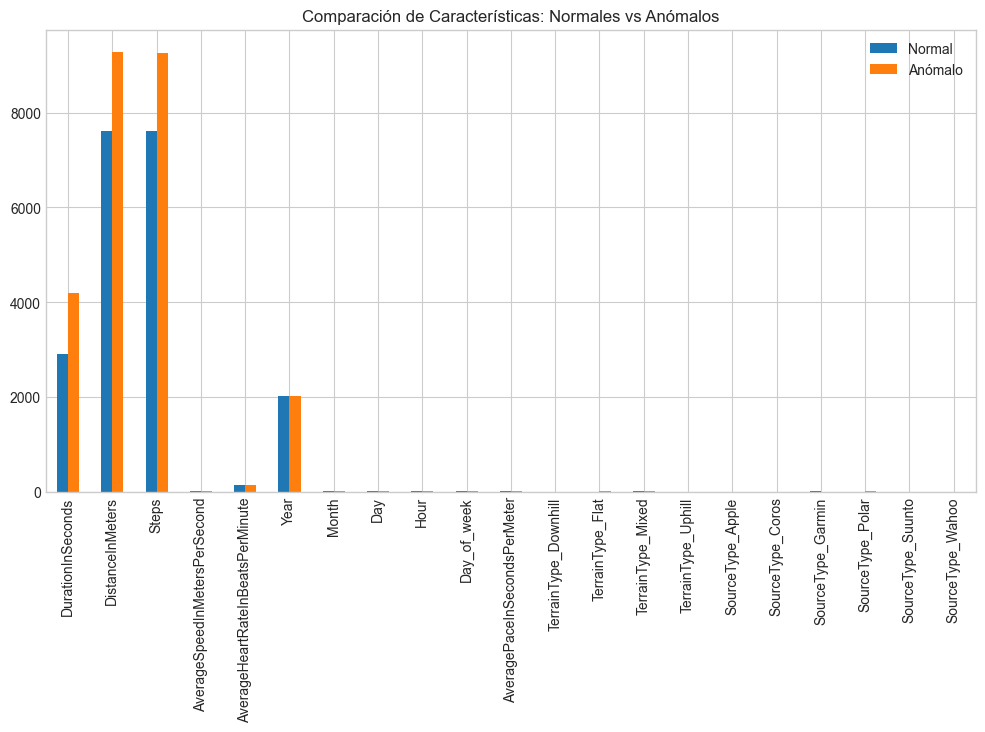

In [ ]:
# Recuperar los valores originales de las anomalías detectadas
anomalies_df = df_original_kmeans.iloc[anomaly_indices_kmeans]

# Calcular la media de las anomalías y la media de todo el dataset
anomalies_mean = anomalies_df.mean()
normal_mean = df_original_kmeans.mean()

# Comparar anomalías vs. valores normales
pd.DataFrame({'Normal': normal_mean, 'Anómalo': anomalies_mean}).plot(kind='bar', figsize=(12,6), title='Comparación de Características: Normales vs Anómalos')
plt.show()

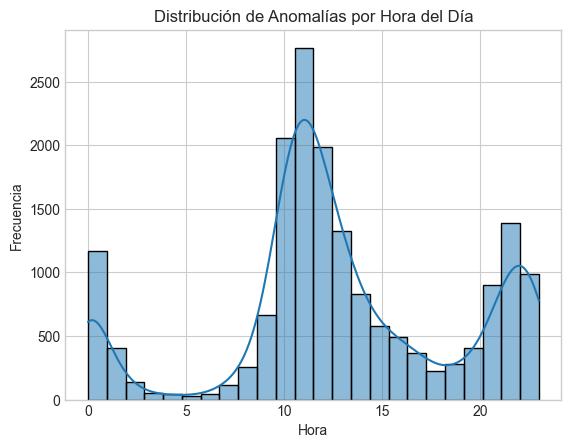

In [ ]:
# Filtrar anomalías en el dataset completo
df_anomalies = df_encoded.iloc[anomaly_indices_kmeans]
sns.histplot(df_anomalies['Hour'], bins=24, kde=True)
plt.title('Distribución de Anomalías por Hora del Día')
plt.xlabel('Hora')
plt.ylabel('Frecuencia')
plt.show()

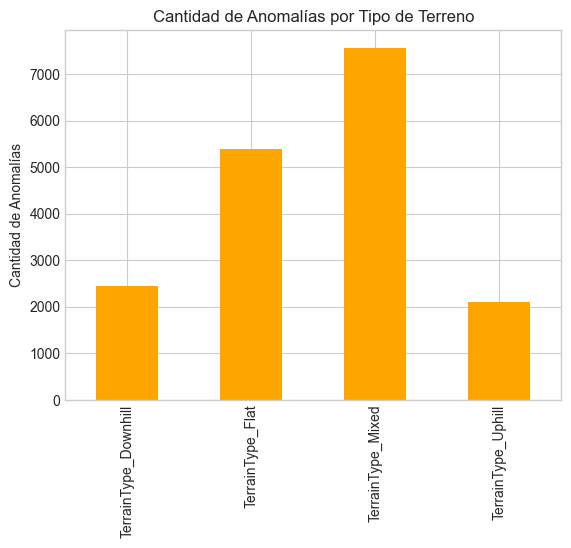

In [ ]:
terrain_cols = ['TerrainType_Downhill', 'TerrainType_Flat', 'TerrainType_Mixed', 'TerrainType_Uphill']
# Sumar anomalías por tipo de terreno en todo el dataset
anomalies_by_terrain = df_anomalies[terrain_cols].sum()

# Graficar la cantidad de anomalías por tipo de terreno
anomalies_by_terrain.plot(kind='bar', color='orange', title='Cantidad de Anomalías por Tipo de Terreno')
plt.ylabel('Cantidad de Anomalías')
plt.show()

In [ ]:
device_cols = ['SourceType_Apple', 'SourceType_Coros', 'SourceType_Garmin', 'SourceType_Polar', 'SourceType_Suunto', 'SourceType_Wahoo']

# Tabla cruzada de anomalías por dispositivo y tipo de terreno en todo el dataset
anomalies_cross = df_anomalies.groupby(device_cols + terrain_cols).size().reset_index(name='count')

# Mostrar los primeros casos ordenados por cantidad de anomalías
anomalies_cross.sort_values('count', ascending=False).head(10)

,SourceType_Apple,SourceType_Coros,SourceType_Garmin,SourceType_Polar,SourceType_Suunto,SourceType_Wahoo,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill,count
8,False,False,False,True,False,False,0.0,0.0,1.0,0.0,3487
2,False,False,False,False,False,True,0.0,1.0,0.0,0.0,3189
4,False,False,False,False,True,False,0.0,0.0,1.0,0.0,2836
18,False,True,False,False,False,False,1.0,0.0,0.0,0.0,1115
9,False,False,False,True,False,False,0.0,1.0,0.0,0.0,1059
0,False,False,False,False,False,True,0.0,0.0,0.0,1.0,771
12,False,False,True,False,False,False,0.0,0.0,1.0,0.0,771
5,False,False,False,False,True,False,0.0,1.0,0.0,0.0,739
11,False,False,True,False,False,False,0.0,0.0,0.0,1.0,706
14,False,False,True,False,False,False,1.0,0.0,0.0,0.0,613


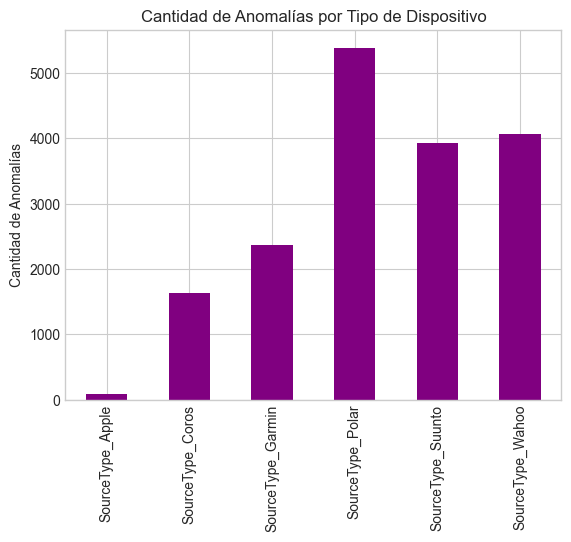

In [ ]:
# Sumar anomalías por tipo de dispositivo en todo el dataset
anomalies_by_device = df_anomalies[device_cols].sum()

# Graficar la cantidad de anomalías por tipo de dispositivo
anomalies_by_device.plot(kind='bar', color='purple', title='Cantidad de Anomalías por Tipo de Dispositivo')
plt.ylabel('Cantidad de Anomalías')
plt.show()

## DBSCAN

Density-Based Spatial Clustering of Applications with Noise es un algoritmo de clustering que agrupa puntos en función de su densidad y será usado para el proceso de identificación de datos atípicos

In [ ]:
df_encoded_scaled_dbscan = df_encoded_scaled.copy()
dbscan = DBSCAN(eps=0.5, min_samples=5)
df_encoded_scaled_dbscan = pd.DataFrame(df_encoded_scaled_dbscan, columns=df_encoded.columns)

dbscan.fit(df_encoded_scaled_dbscan)

cluster_labels = dbscan.labels_

# Add cluster labels to the DataFrame using .loc
df_encoded_scaled_dbscan.loc[:, 'cluster_labels'] = cluster_labels

display(df_encoded_scaled_dbscan.head())

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week,...,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill,SourceType_Apple,SourceType_Coros,SourceType_Garmin,SourceType_Polar,SourceType_Suunto,SourceType_Wahoo,cluster_labels
0,-0.237263,-0.234098,-0.135519,-0.071286,0.123177,-0.712319,0.394093,1.692226,1.111445,-1.589989,...,-0.412420,0.433716,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,0
1,-1.052901,-1.058596,-1.164279,-0.172038,-2.799129,-0.712319,0.394093,1.692226,1.630391,-1.589989,...,2.424712,-2.305656,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,-1
2,-1.018327,-1.026657,-1.121815,-0.168424,-1.554443,-0.712319,0.394093,1.692226,1.630391,-1.589989,...,-0.412420,0.433716,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,0
3,-0.399526,-0.390892,-0.392295,-0.062250,0.177294,-0.712319,0.394093,1.692226,1.630391,-1.589989,...,-0.412420,0.433716,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,0
4,0.579162,0.415325,0.635802,-0.187399,0.014943,-0.712319,0.394093,1.692226,1.284427,-1.589989,...,-0.412420,0.433716,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,0


PCA en 2 dimensiones

In [ ]:

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_encoded_scaled_dbscan.drop(columns=['cluster_labels']))

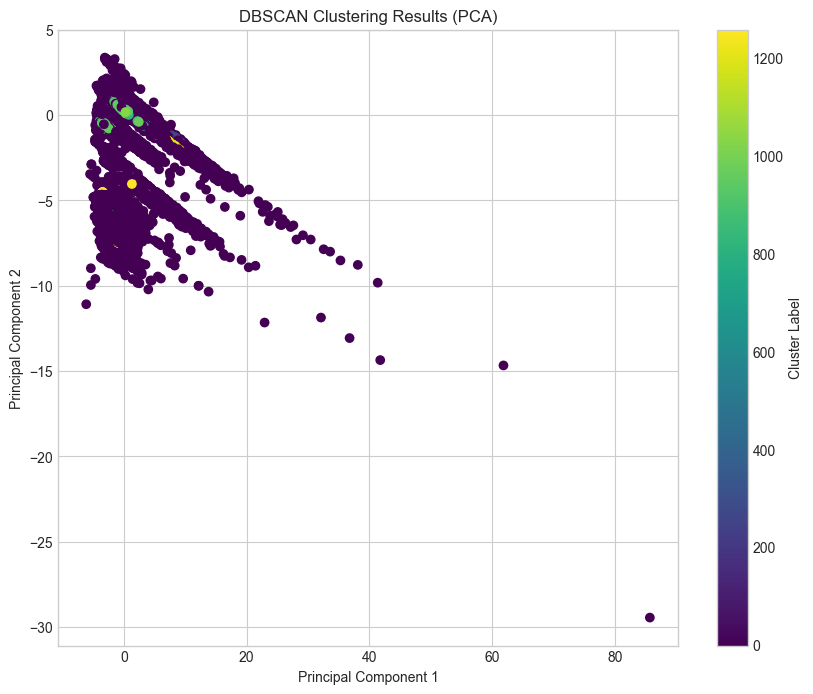

In [ ]:
# Create a scatter plot of the data points, colored by cluster
plt.figure(figsize=(10, 8))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_encoded_scaled_dbscan['cluster_labels'], cmap='viridis')
plt.title('DBSCAN Clustering Results (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

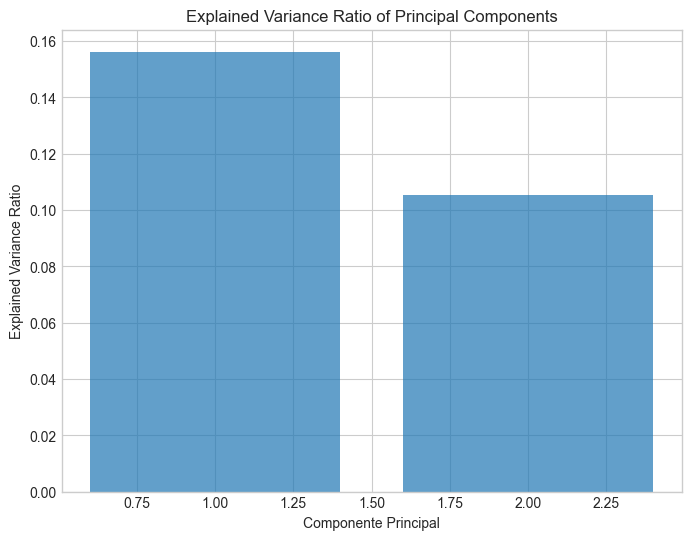

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, 3), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel('Componente Principal')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Aplicar PCA con 3 componentes
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_encoded_scaled_dbscan.drop(columns=['cluster_labels']))

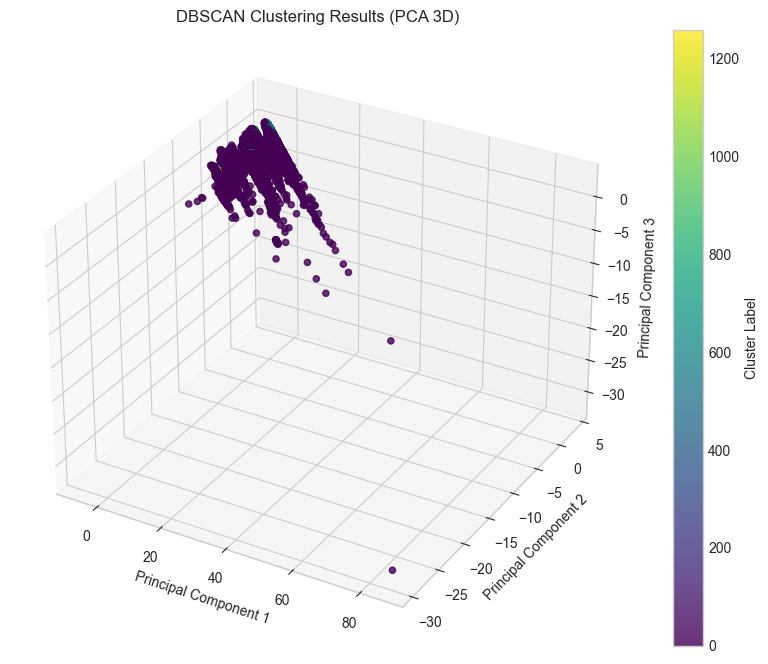

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos con sus clusters
scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2],
                     c=df_encoded_scaled_dbscan['cluster_labels'], cmap='viridis', alpha=0.8)

ax.set_title('DBSCAN Clustering Results (PCA 3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.colorbar(scatter, label="Cluster Label")
plt.show()

- Si los puntos forman grupos definidos, significa que DBSCAN ha encontrado patrones claros en los datos. En este caso no es muy evidente

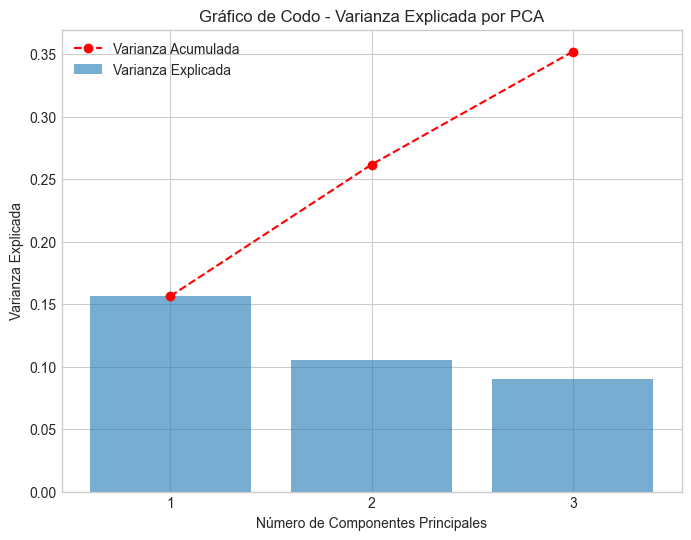

In [ ]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)  # Suma acumulada

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Varianza Explicada')
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='red', label='Varianza Acumulada')

plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.title('Gráfico de Codo - Varianza Explicada por PCA')
plt.legend()
plt.xticks(range(1, len(explained_variance) + 1))
plt.show()

- Las barras azules representan la varianza explicada por cada componente principal.
- La línea roja punteada muestra la varianza acumulada a medida que se agregan más componentes.

In [ ]:
anomalies = df_encoded_scaled_dbscan[df_encoded_scaled_dbscan['cluster_labels'] == -1]
anomalies.head()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week,...,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill,SourceType_Apple,SourceType_Coros,SourceType_Garmin,SourceType_Polar,SourceType_Suunto,SourceType_Wahoo,cluster_labels
1,-1.052901,-1.058596,-1.164279,-0.172038,-2.799129,-0.712319,0.394093,1.692226,1.630391,-1.589989,...,2.424712,-2.305656,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,-1
6,1.073810,-0.148740,-0.096705,-0.725949,-0.742691,-0.712319,0.394093,1.692226,1.457409,-1.589989,...,-0.412420,0.433716,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,-1
12,-1.067831,-1.084527,-1.198450,-0.357277,-1.283859,-0.712319,0.607611,-1.643095,-2.348189,-1.076958,...,-0.412420,0.433716,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,-1
13,0.182736,0.062775,0.297084,-0.181978,1.692564,-0.712319,0.394093,1.692226,1.457409,-1.589989,...,2.424712,-2.305656,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,-1
16,1.561386,1.366599,1.840389,-0.159388,0.718462,-0.712319,0.394093,1.692226,1.284427,-1.589989,...,-0.412420,0.433716,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,-1


In [ ]:
print('DBSCAN detected anomalies:', len(anomalies))

DBSCAN detected anomalies: 80642


## SVM

In [ ]:
df_encoded_scaled_svm = df_encoded_scaled.copy()

# 2. One-Class SVM
one_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.02)
one_svm.fit(df_encoded_scaled_svm)
svm_pred = one_svm.predict(df_encoded_scaled_svm)
svm_anomalies = np.sum(svm_pred == -1)
print('One-Class SVM detected anomalies:', svm_anomalies)


One-Class SVM detected anomalies: 6988


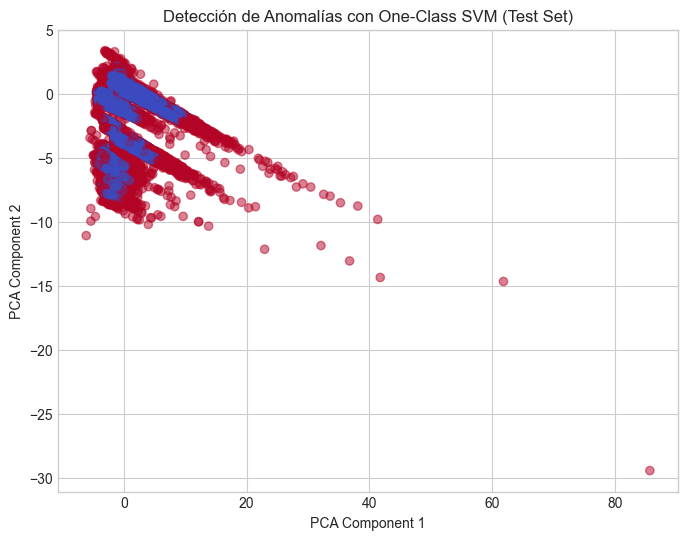

In [ ]:
# Scatter plot con anomalías detectadas en el conjunto de prueba
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_encoded_scaled_svm)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=(svm_pred == -1), cmap='coolwarm', alpha=0.5)
plt.title('Detección de Anomalías con One-Class SVM (Test Set)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## Isolation Forest Model

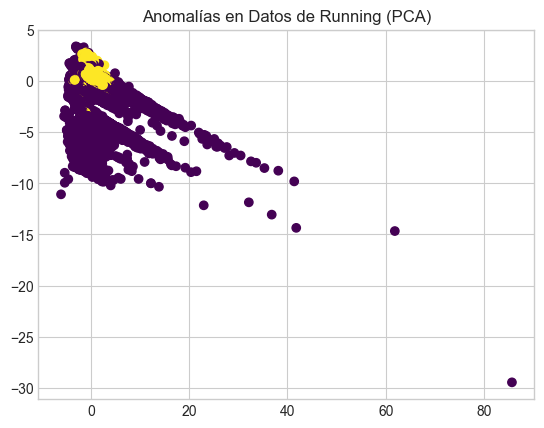

In [ ]:
df_encoded_scaled_ifm = df_encoded_scaled.copy()
df_encoded_scaled_ifm = pd.DataFrame(df_encoded_scaled_ifm, columns=df_encoded.columns)

modelo = IsolationForest(
    n_estimators=100, 
    contamination=0.2,  # Asume un 20% de anomalías
    random_state=42
)
modelo.fit(df_encoded_scaled_ifm)  # No se usan etiquetas (y_label)
df_encoded_scaled_ifm['isAnomaly'] = modelo.predict(df_encoded_scaled_ifm)  # 1 = normal, -1 = anomalía

datos_anomalos = df_encoded_scaled_ifm[df_encoded_scaled_ifm['isAnomaly'] == -1]


# Reducir a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_encoded_scaled_ifm.drop(columns='isAnomaly'))

# Graficar
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_encoded_scaled_ifm['isAnomaly'], cmap='viridis')
plt.title('Anomalías en Datos de Running (PCA)')
plt.show()

In [ ]:
print('Isolation Forest detected anomalies: ', len(datos_anomalos))

Isolation Forest detected anomalies:  69914


In [ ]:
datos_anomalos.head()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week,...,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill,SourceType_Apple,SourceType_Coros,SourceType_Garmin,SourceType_Polar,SourceType_Suunto,SourceType_Wahoo,isAnomaly
1,-1.052901,-1.058596,-1.164279,-0.172038,-2.799129,-0.712319,0.394093,1.692226,1.630391,-1.589989,...,2.424712,-2.305656,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,-1
6,1.073810,-0.148740,-0.096705,-0.725949,-0.742691,-0.712319,0.394093,1.692226,1.457409,-1.589989,...,-0.412420,0.433716,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,-1
13,0.182736,0.062775,0.297084,-0.181978,1.692564,-0.712319,0.394093,1.692226,1.457409,-1.589989,...,2.424712,-2.305656,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,-1
16,1.561386,1.366599,1.840389,-0.159388,0.718462,-0.712319,0.394093,1.692226,1.284427,-1.589989,...,-0.412420,0.433716,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,-1
19,0.417291,0.235753,0.211824,-0.212249,-0.147407,-0.712319,0.394093,1.692226,1.457409,-1.589989,...,2.424712,-2.305656,-0.07763,-0.015868,-0.182052,0.298818,-0.165896,-0.106563,-0.108469,-1


### Conclusiones de modelamiento

- Resultados generales de cada modelo:
    - KMeans clustering detected anomalies: 17479
    - DBSCAN detected anomalies: 80642
    - One-Class SVM detected anomalies: 3491
    - Isolation Forest detected anomalies:  69913
- A partir del modelo de K-Means, se identificaron 17479 registros atípicos. Estos fueron detectados al analizar los datos que se alejan significativamente de su centroide. Para determinar las anomalías, se consideraron como outliers aquellos puntos cuya distancia al centroide superaba el percentil 95, marcando así el 5% de los puntos más alejados de su cluster. Además, se observó que los registros atípicos se presentaban principalmente en terrenos flat y mixed, con mayor porcentaje en mixed. En cuanto a los dispositivos, Polar fue el que registró la mayor cantidad de datos atípicos. La hora con mayor presencia de anomalías fue las 11:00 AM. Al analizar la combinación de terreno y dispositivo, se identificó que la mayor cantidad de registros atípicos correspondía a Polar en terreno Mixed.

- De todos los modelos utilizados, DBSCAN es el que mejor detecta outliers o ruido, ya que no requiere configurar tantos parámetros desconocidos de antemano, a diferencia de los otros modelos. Por ejemplo, Isolation Forest depende del porcentaje de anomalías esperado dentro del conjunto de datos, lo que significa que al aumentar este valor, también se incrementa la cantidad de datos detectados como atípicos. Por lo tanto, al establecer el parámetro de contamination en 0.2, estamos indicando que se espera que el 20% de los datos sean anomalías, lo que lleva a obtener una cantidad de outliers similar a la detectada por DBSCAN.

## Conclusión

- Ante la pregunta smart: ¿Es posible identificar actividades de running atípicas o sospechosas con datos de los últimos 5 meses (10/2024 - 02/2025) utilizando métricas cómo velocidad, distancia, elevación, tiempo y frecuencia cardiaca?. Sí, es posible. El análisis de variables clave como velocidad, distancia, elevación, tiempo y frecuencia cardiaca permite detectar anomalías que podrían indicar errores de registro. La identificación de valores atípicos en métricas como la velocidad y la elevación sugiere que algunos registros presentan comportamientos inusuales que no siguen la distribución esperada. Sin embargo, es importante considerar que la presencia de valores atípicos no implica automáticamente fraude o actividad sospechosa. Factores como el tipo de terreno, las condiciones climáticas, la variabilidad en los dispositivos de medición y el estado físico del atleta pueden influir en los resultados y generar datos aparentemente anómalos sin que haya una alteración intencionada.